# COVID-19 data exploration and monitoring
With credits to Saeed Amen at Cuemacro (www.cuemacro.com)

With inspiration from Saeed, this notebook intends to explore and visualise the trends of case growth in COVID-19 cases. In particular, I hope to understand more about the density of the infections relative to the population of a particular area.

Currently, the sources for this notebook come from the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) repository at https://github.com/CSSEGISandData/COVID-19, the source for the data in [another dashboard](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

This repository contains data in multiple forms. As of the time of writing, there are WHO situation reports as well as data from the CSSE COVID-19 dataset. In each of these datasets, there are daily snapshot reports, as well as the time series of each of the datasets. Lastly, there is a directory containing archived data. The CSSE COVID-19 dataset also includes a look-up table for ISO FIPS UID.

In [1]:
REPO_PATH = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
CSSE_DATA_PATH = REPO_PATH + "csse_covid_19_data/"
TIME_SERIES_PATH = CSSE_DATA_PATH + "csse_covid_19_time_series/"

In [2]:
CSV_URL = {}
CSV_URL['CONFIRMED'] = "time_series_covid19_confirmed_global.csv"
CSV_URL['DEATHS'] = "time_series_covid19_deaths_global.csv"
CSV_URL['RECOVERED'] = "time_series_covid19_recovered_global.csv"
CSV_URL['US_CONFIRMED'] = "time_series_covid19_confirmed_US.csv"
CSV_URL['US_DEATHS'] = "time_series_covid19_deaths_US.csv"

In [3]:
# World Bank population data
WORLDBANK_API_URL = "http://api.worldbank.org/v2/en/indicator/"
WORLDBANK_API_CSV = "?downloadformat=csv"

def _worldbank_url(wb_code):
    return WORLDBANK_API_URL + wb_code + WORLDBANK_API_CSV

WORLDBANK_POP_CODE = "SP.POP.TOTL"
WORLDBANK_POP_ZIP = _worldbank_url(WORLDBANK_POP_CODE)
WORLDBANK_URBPOP_CODE = "SP.URB.TOTL.IN.ZS"
WORLDBANK_URB_POP_ZIP = _worldbank_url(WORLDBANK_URBPOP_CODE)

In [4]:
GOOG_MOBILITY_URL = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"

In [5]:
import cufflinks as cf
import datetime as dt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile as zf
import csv
import difflib
import io
import itertools
import os
import requests

print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
#print(f"Zipfile version: {zf.__version__}")

%matplotlib inline

Numpy version: 1.18.4
Pandas version: 1.0.3


In [6]:
# check renderer for plotly
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

## Confirmed cases

Research questions to be addressed:
1. Has the pace of infections slowed in the US and other (selected) countries?
    * Look at the rate of new cases
        * Does it have a natural tailing off just numerically though? If so, probably related to the below point?
2. Is there a "natural" proportion of the population which will be infected before it tails off?
    * Examine the population in each area, and 
3. How can I identify "regimes" of infection transmission?

In [7]:
df_us_confirmed = (pd.read_csv(TIME_SERIES_PATH + CSV_URL['US_CONFIRMED'])
                   .rename(columns={'Long_': 'Long',
                                    'Country_Region': 'Country/Region',
                                    'Province_State': 'Province/State'
                                   })
                  )
df_confirmed = pd.read_csv(TIME_SERIES_PATH + CSV_URL['CONFIRMED'])

In [8]:
set(df_us_confirmed.columns) - set(df_confirmed.columns)

{'Admin2', 'Combined_Key', 'FIPS', 'UID', 'code3', 'iso2', 'iso3'}

In [9]:
set(df_confirmed.columns) - set(df_us_confirmed.columns)

set()

In [10]:
def _process_columns(col_name):
        try: 
            return dt.datetime.strptime(col_name, '%m/%d/%y').date()
        except ValueError:
            try:
                return dt.datetime.strptime(col_name, '%m/%d/%Y').date()
            except ValueError:
                return col_name

In [11]:
df_by_country = (pd.pivot_table(df_confirmed.drop(columns=['Lat', 'Long', 'Province/State']),
                                index=['Country/Region'],
                                aggfunc=np.sum
                               )
                 .rename(columns=_process_columns)
                 .transpose()
                 .sort_index()
                )

## Global

In [12]:
def cases_and_rate(series):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300) 
    ax_2 = ax.twinx()
    ax.set_ylabel('Number of cases')
    ax_2.set_ylabel('pct_change')
    ax.plot(series)
    ax_2.plot(series.pct_change(),
              color='tab:red'
             )
    plt.show()

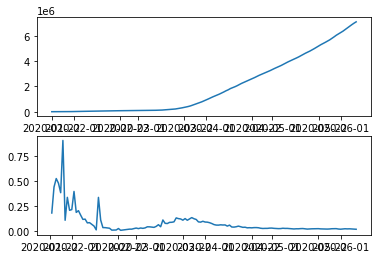

In [13]:
GL_fig, GL_axs = plt.subplots(2)
GL_axs[0].plot(df_by_country.sum(axis=1))
GL_axs[1].plot(df_by_country.sum(axis=1).pct_change())

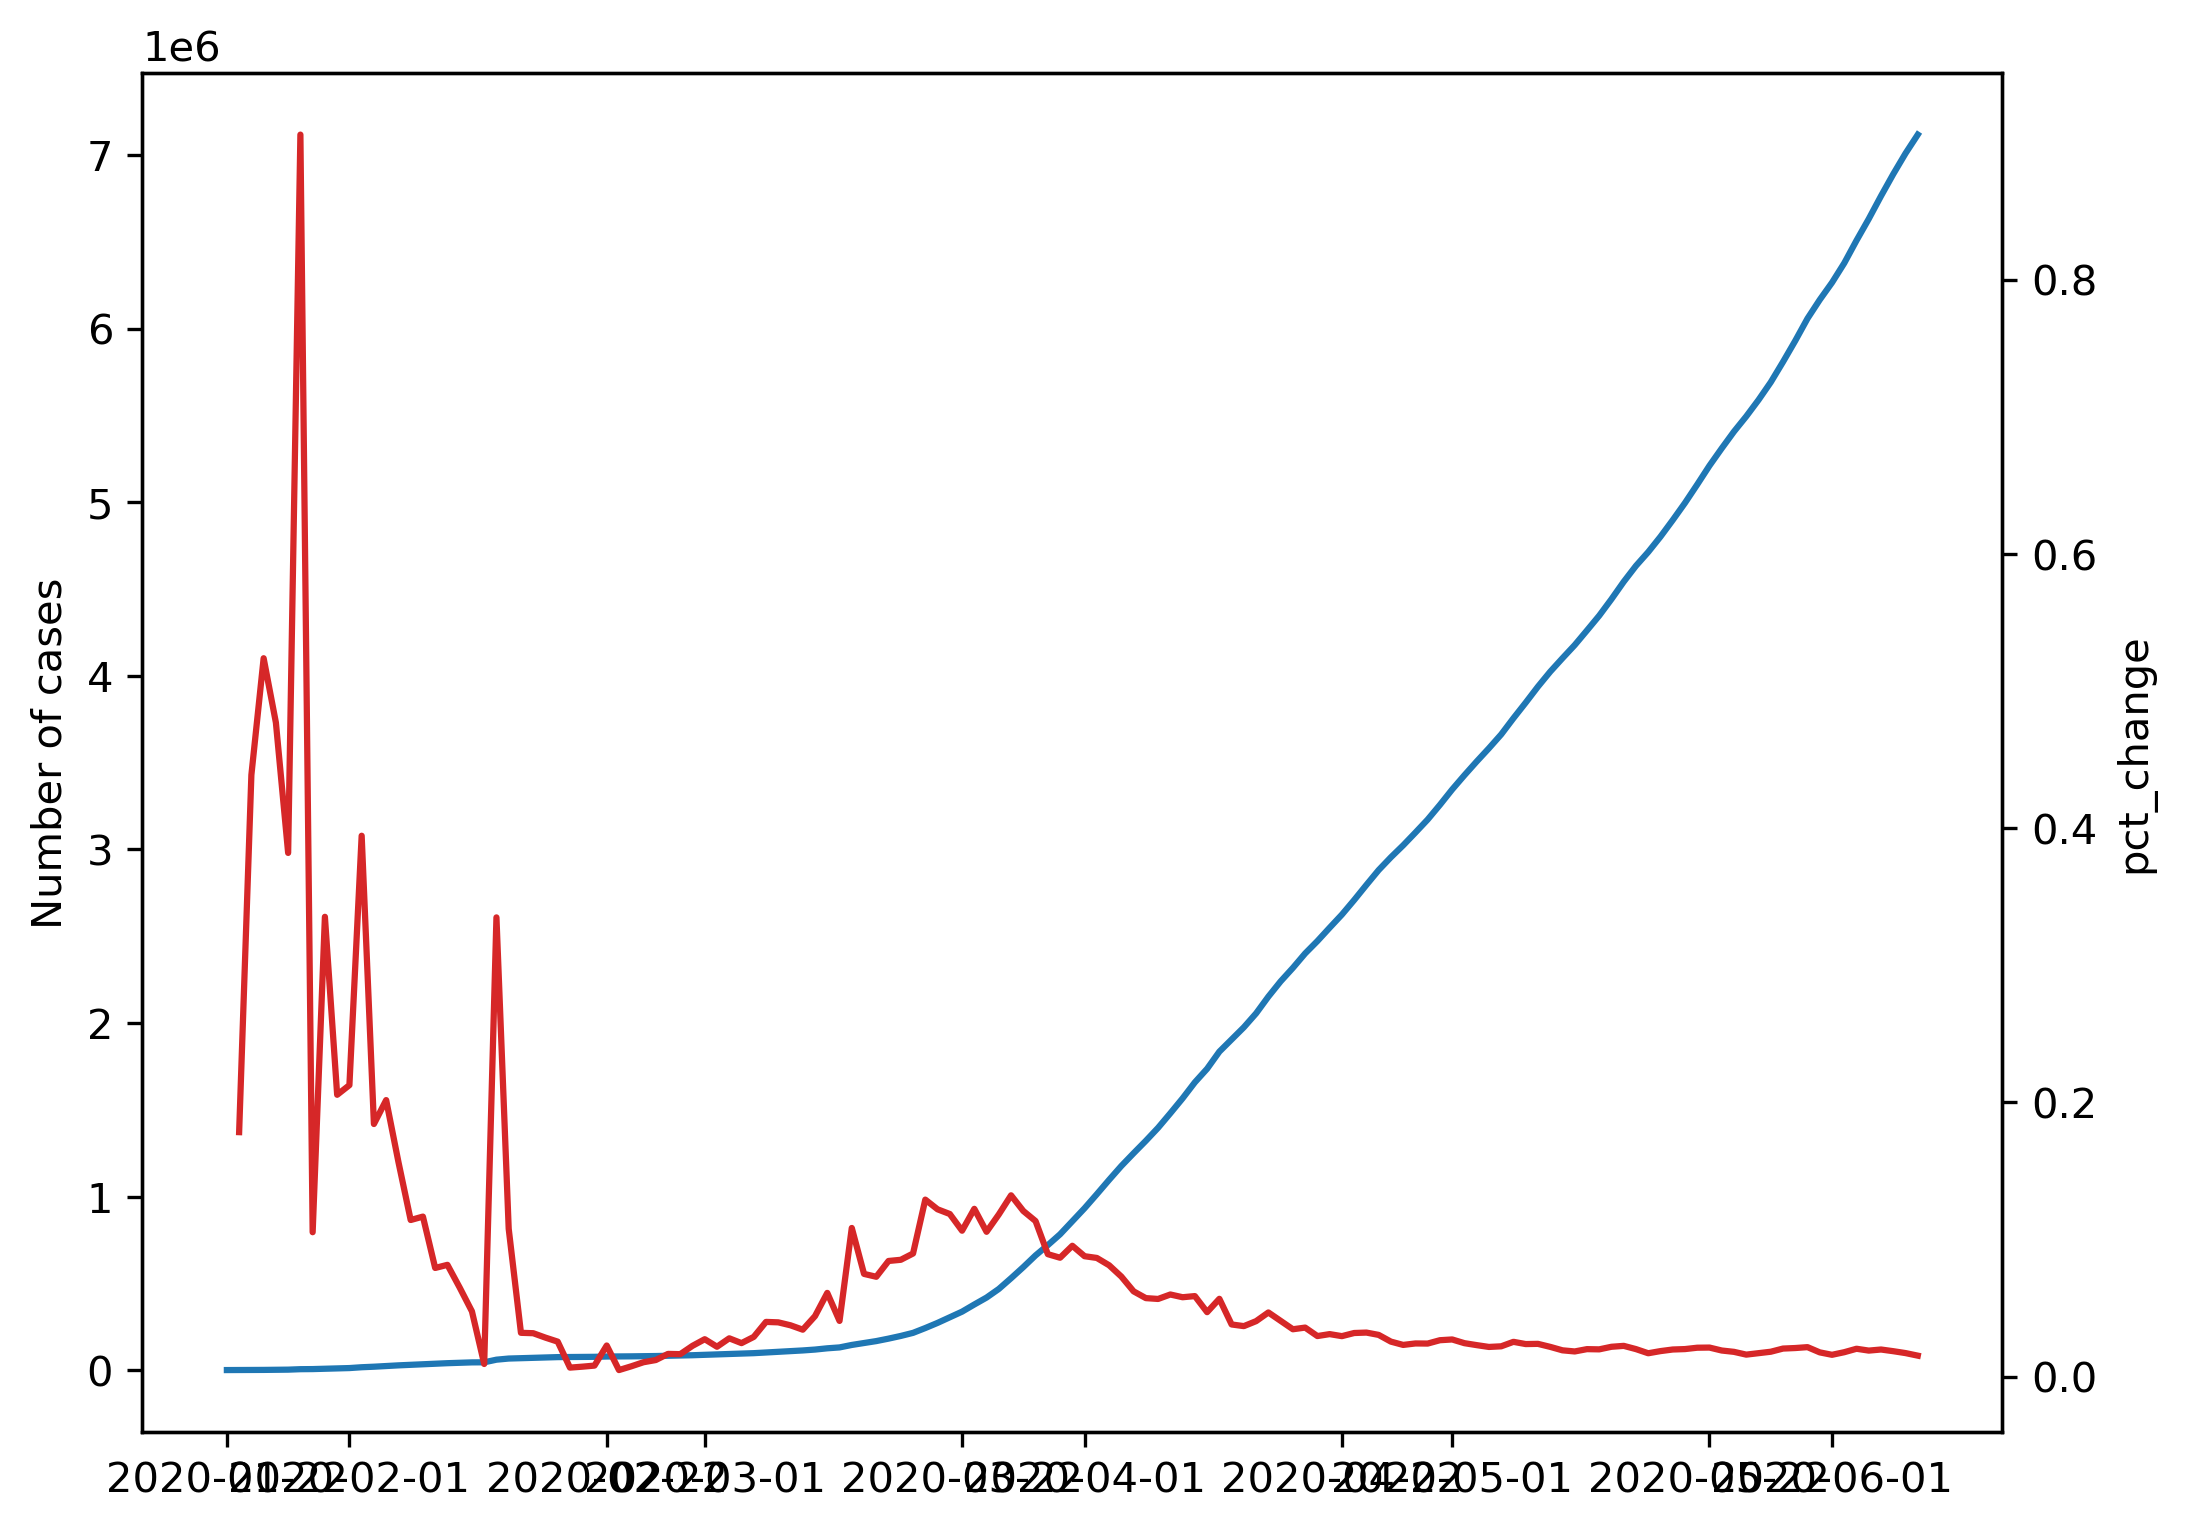

In [14]:
cases_and_rate(df_by_country.sum(axis=1))

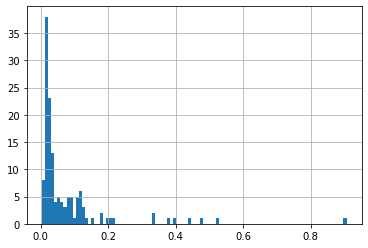

In [15]:
df_by_country.sum(axis=1).pct_change().hist(bins=100)

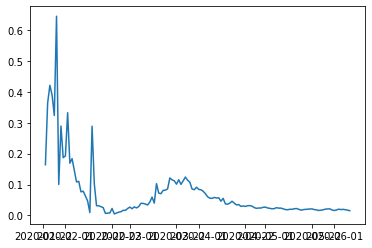

In [16]:
np.log(df_by_country.sum(axis=1)).diff().plot()

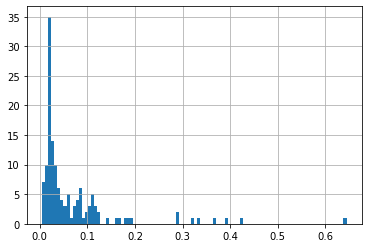

In [17]:
np.log(df_by_country.sum(axis=1)).diff().hist(bins=100)

## United Kingdom

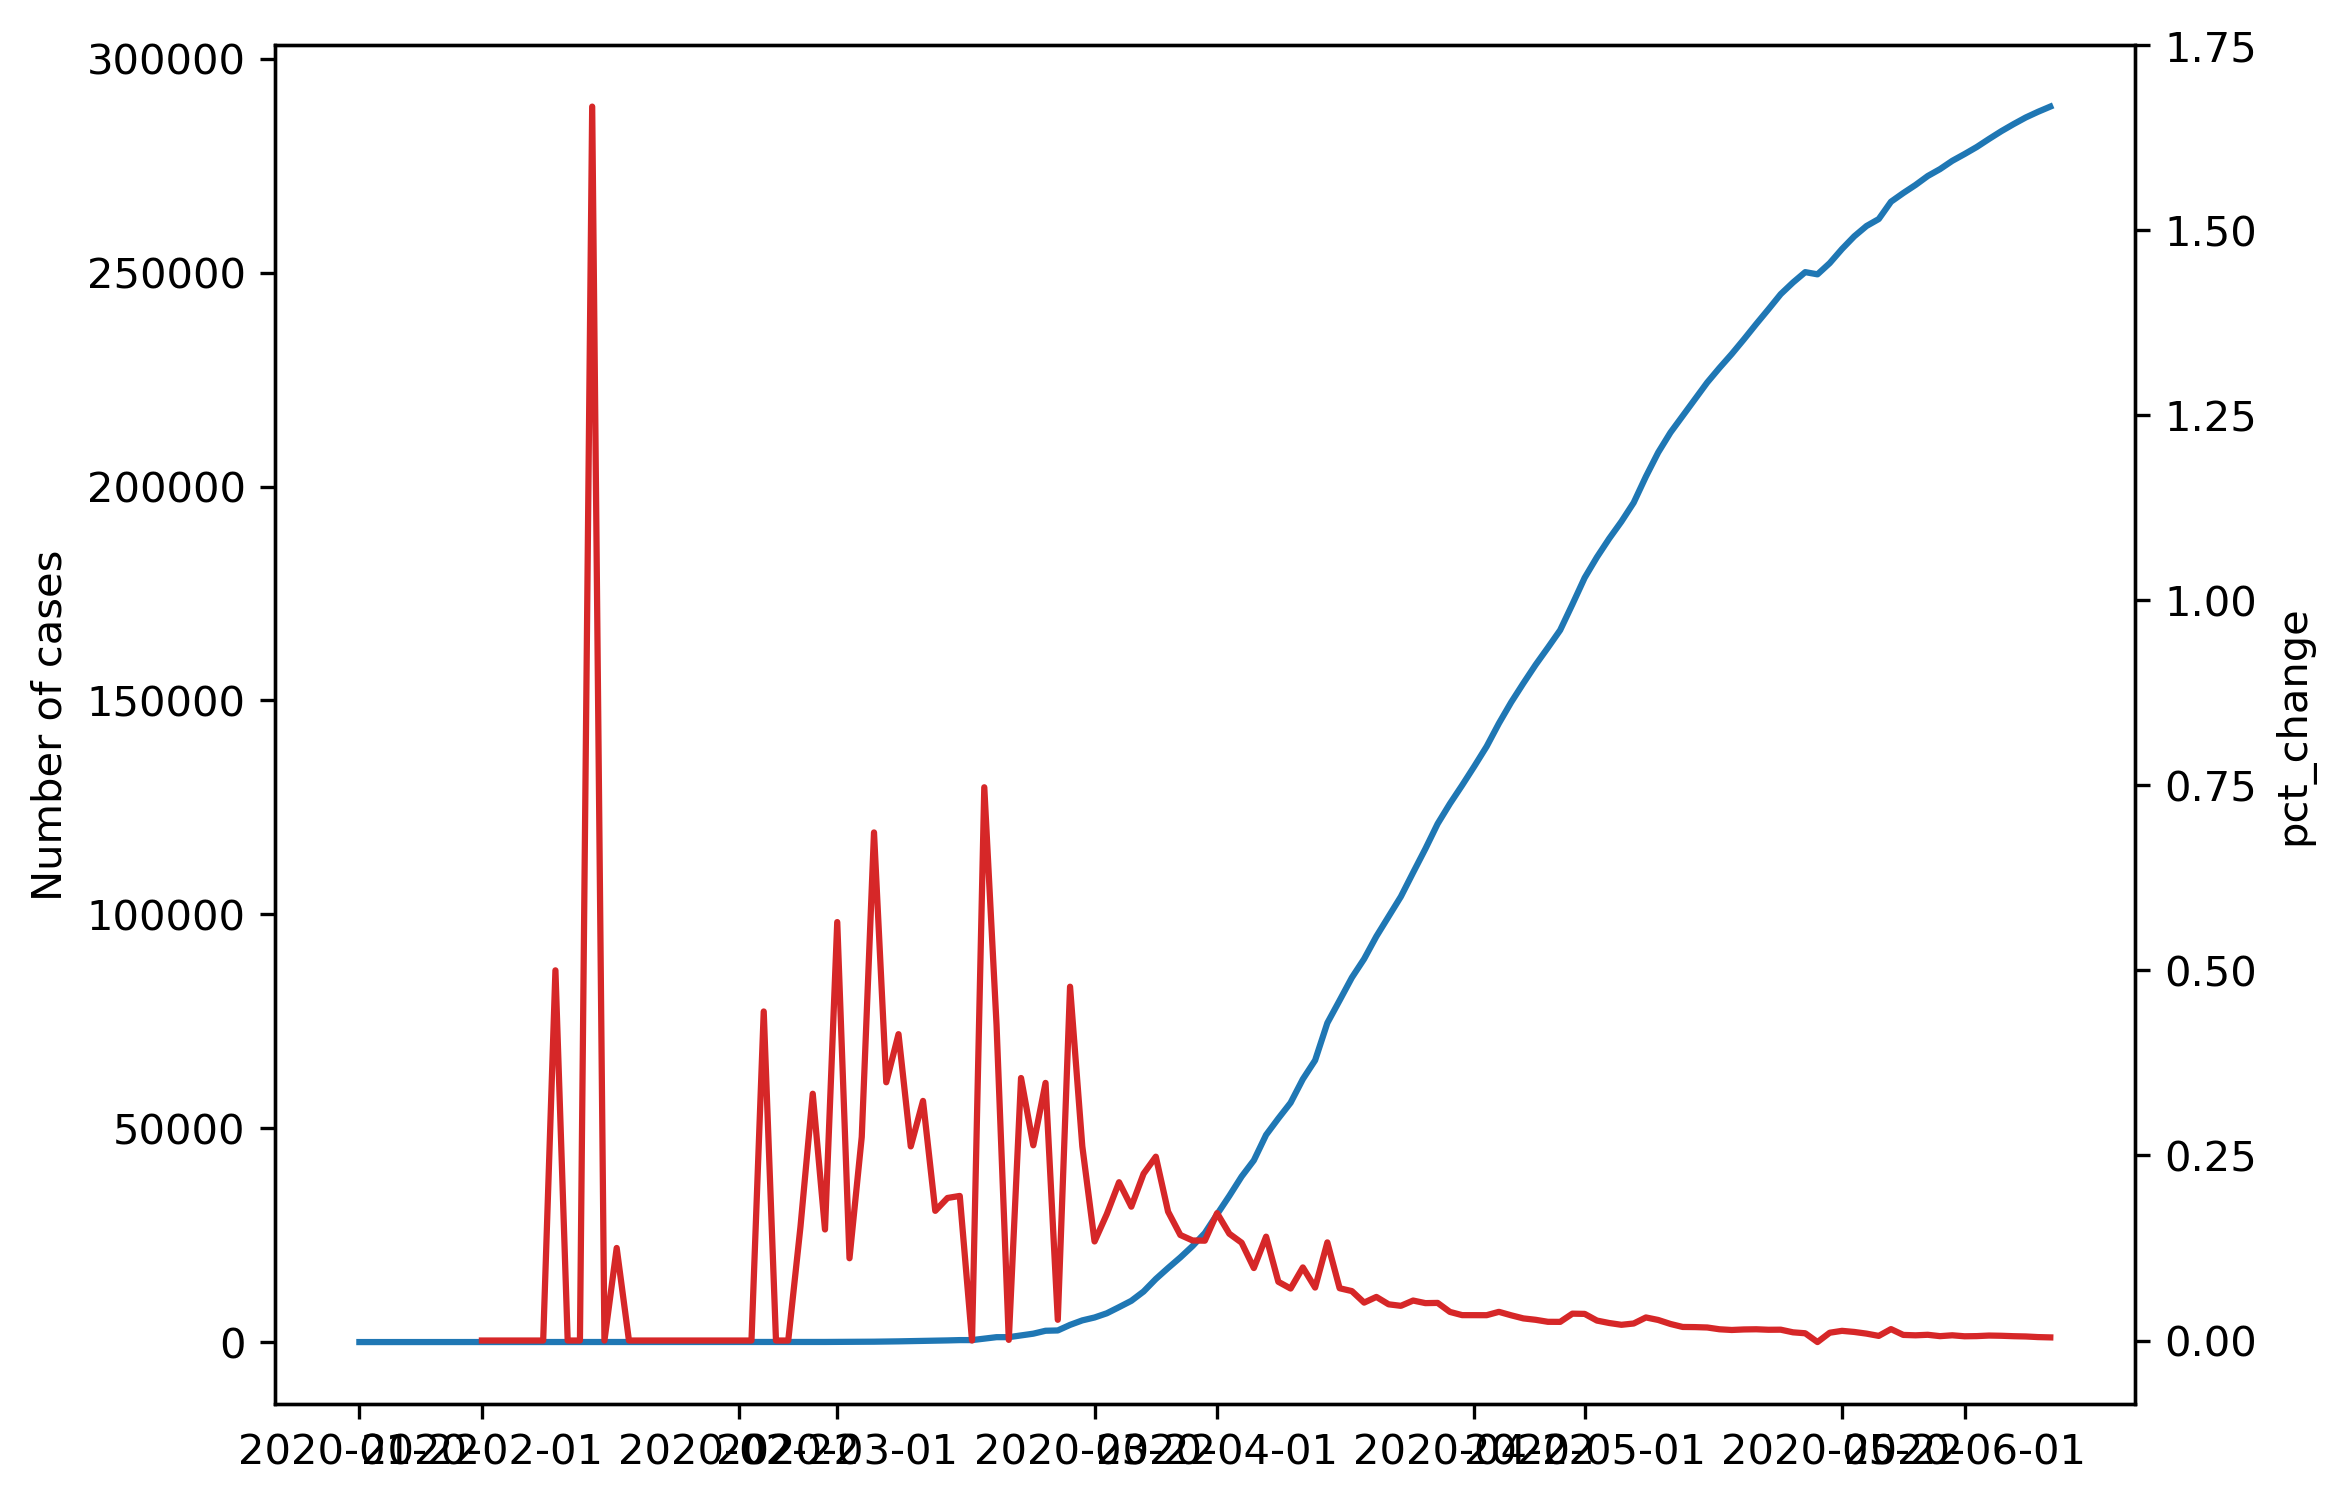

In [18]:
cases_and_rate(df_by_country['United Kingdom'])

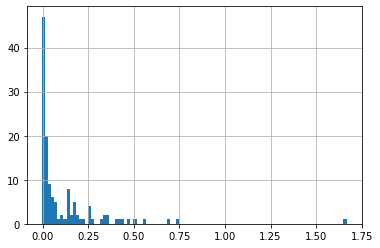

In [19]:
(df_by_country['United Kingdom'].pct_change()
 .replace([np.inf, -np.inf], np.nan)
 .dropna()
 .hist(bins=100)
)

## Singapore

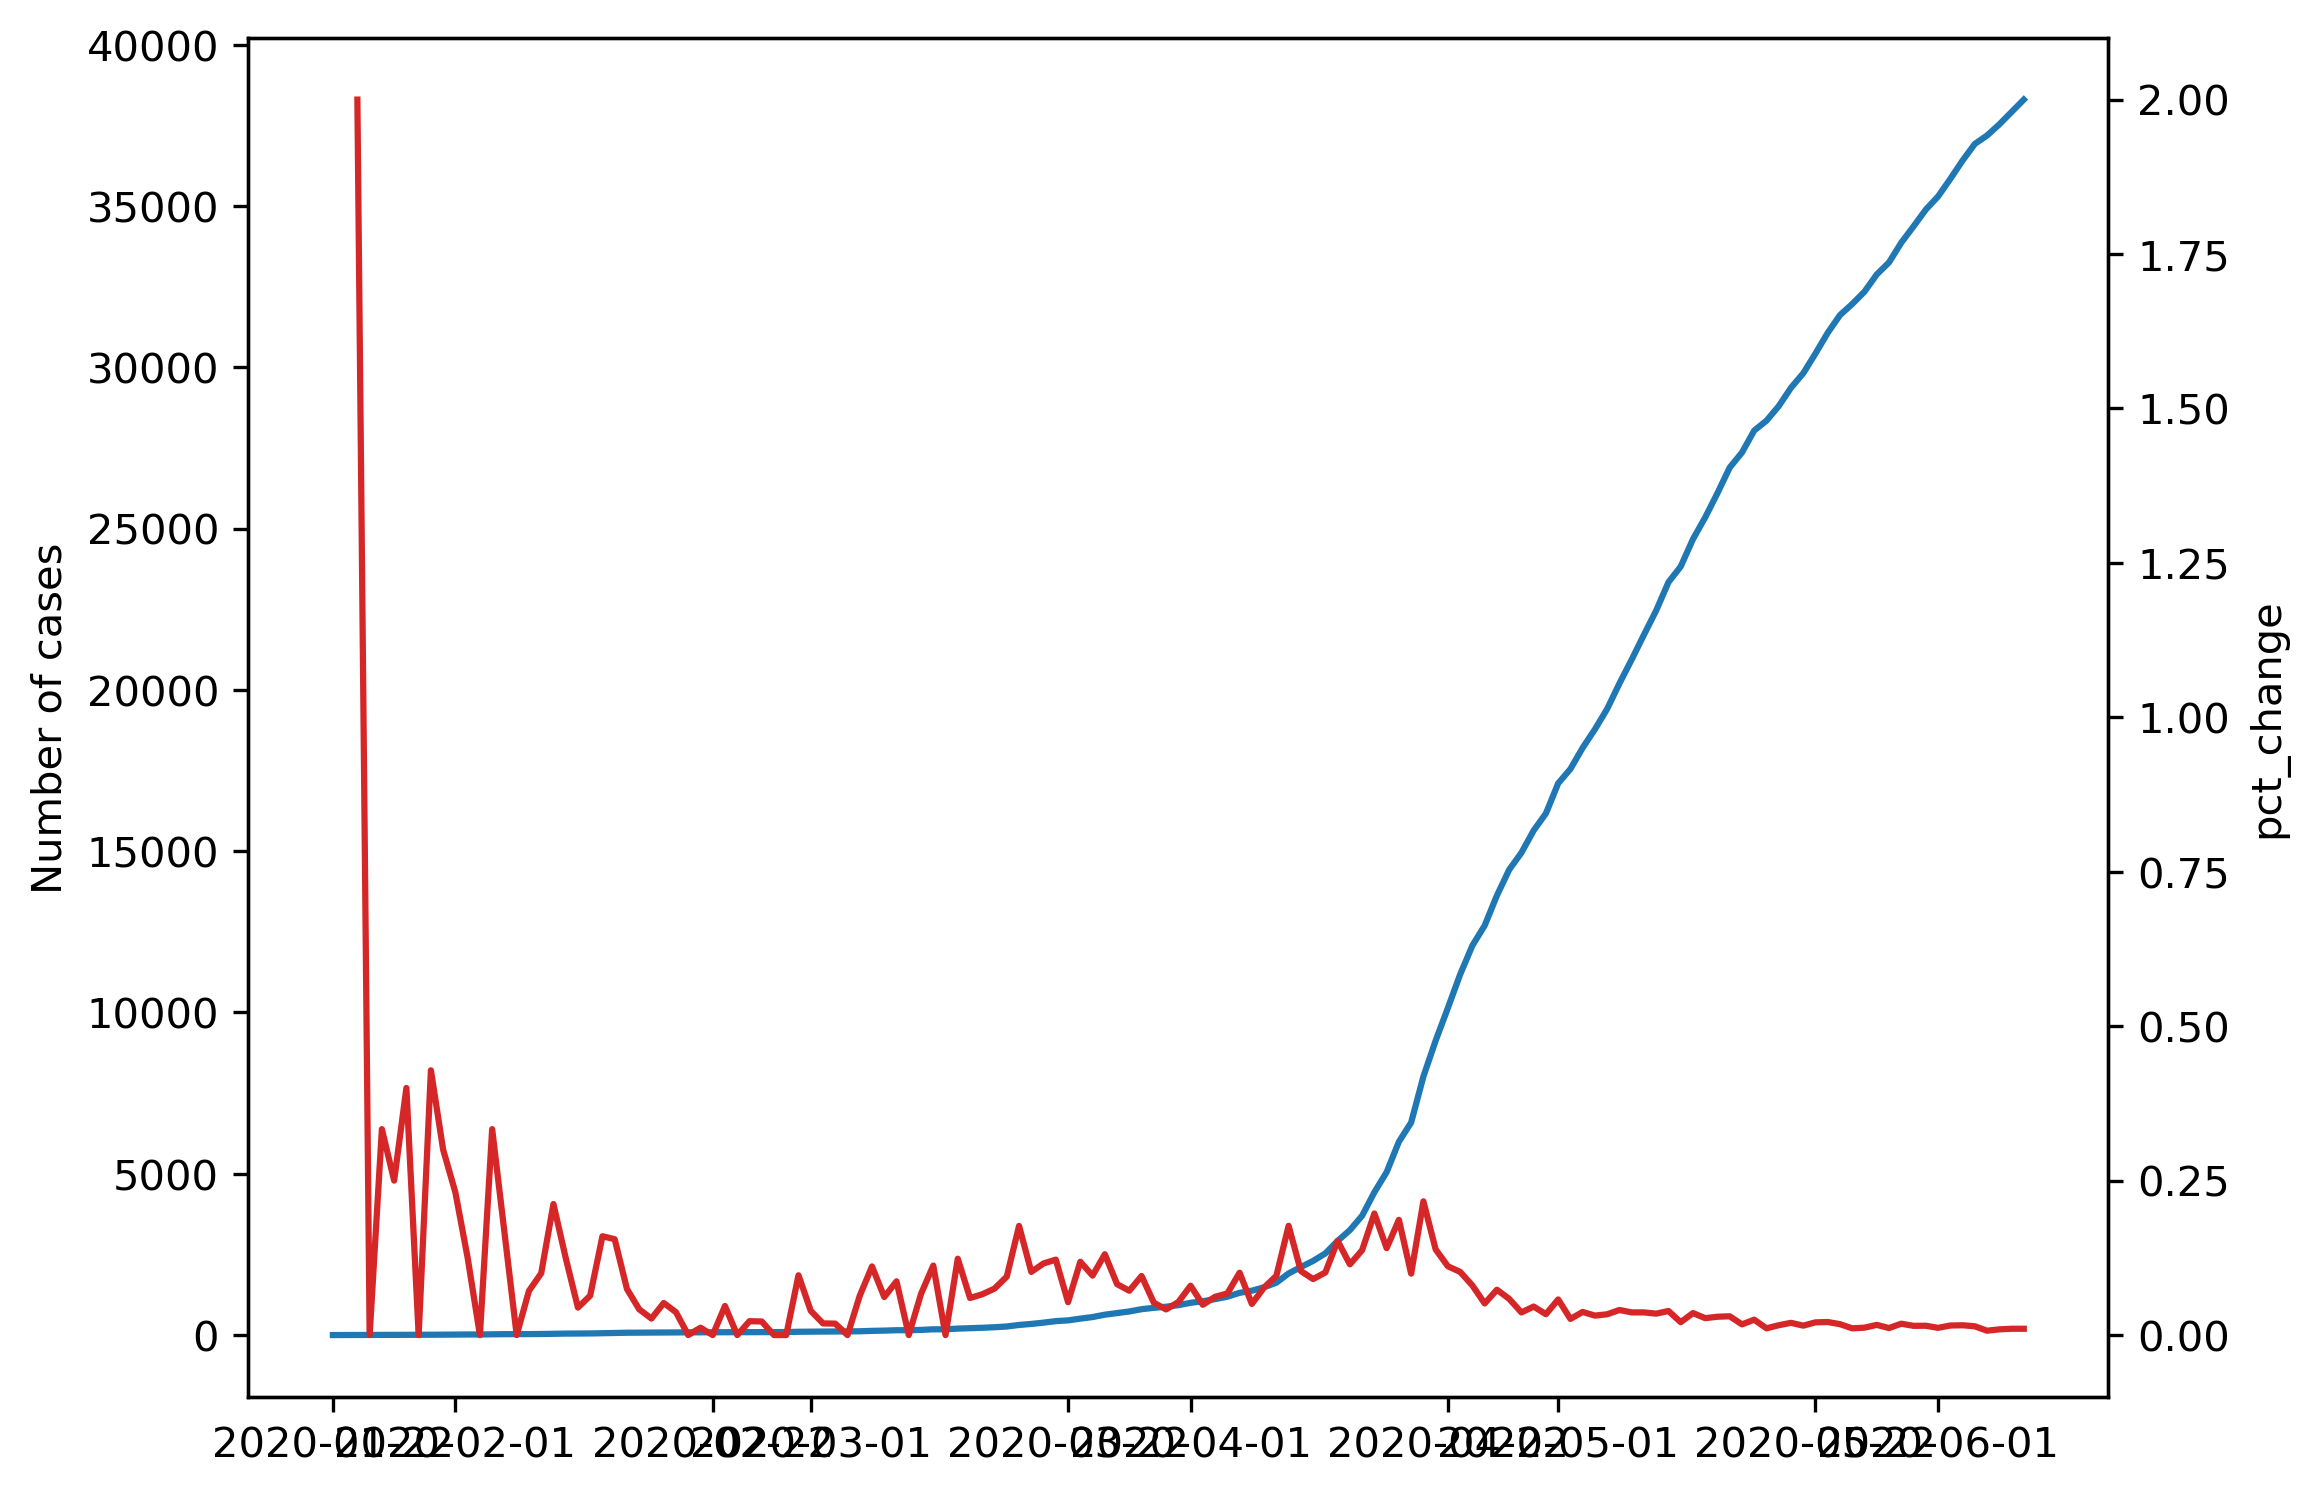

In [20]:
cases_and_rate(df_by_country['Singapore'])

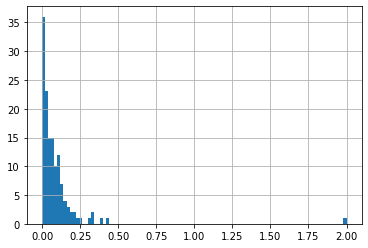

In [21]:
(df_by_country['Singapore'].pct_change()
 .dropna()
 .replace([np.inf, -np.inf], np.nan)
 .hist(bins=100)
)

## Germany

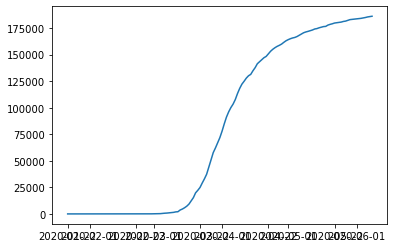

In [22]:
df_by_country['Germany'].plot()

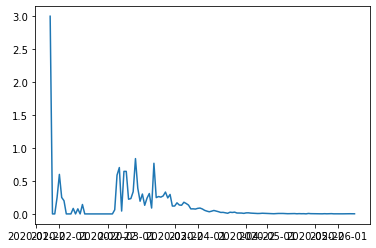

In [23]:
df_by_country['Germany'].pct_change().plot()

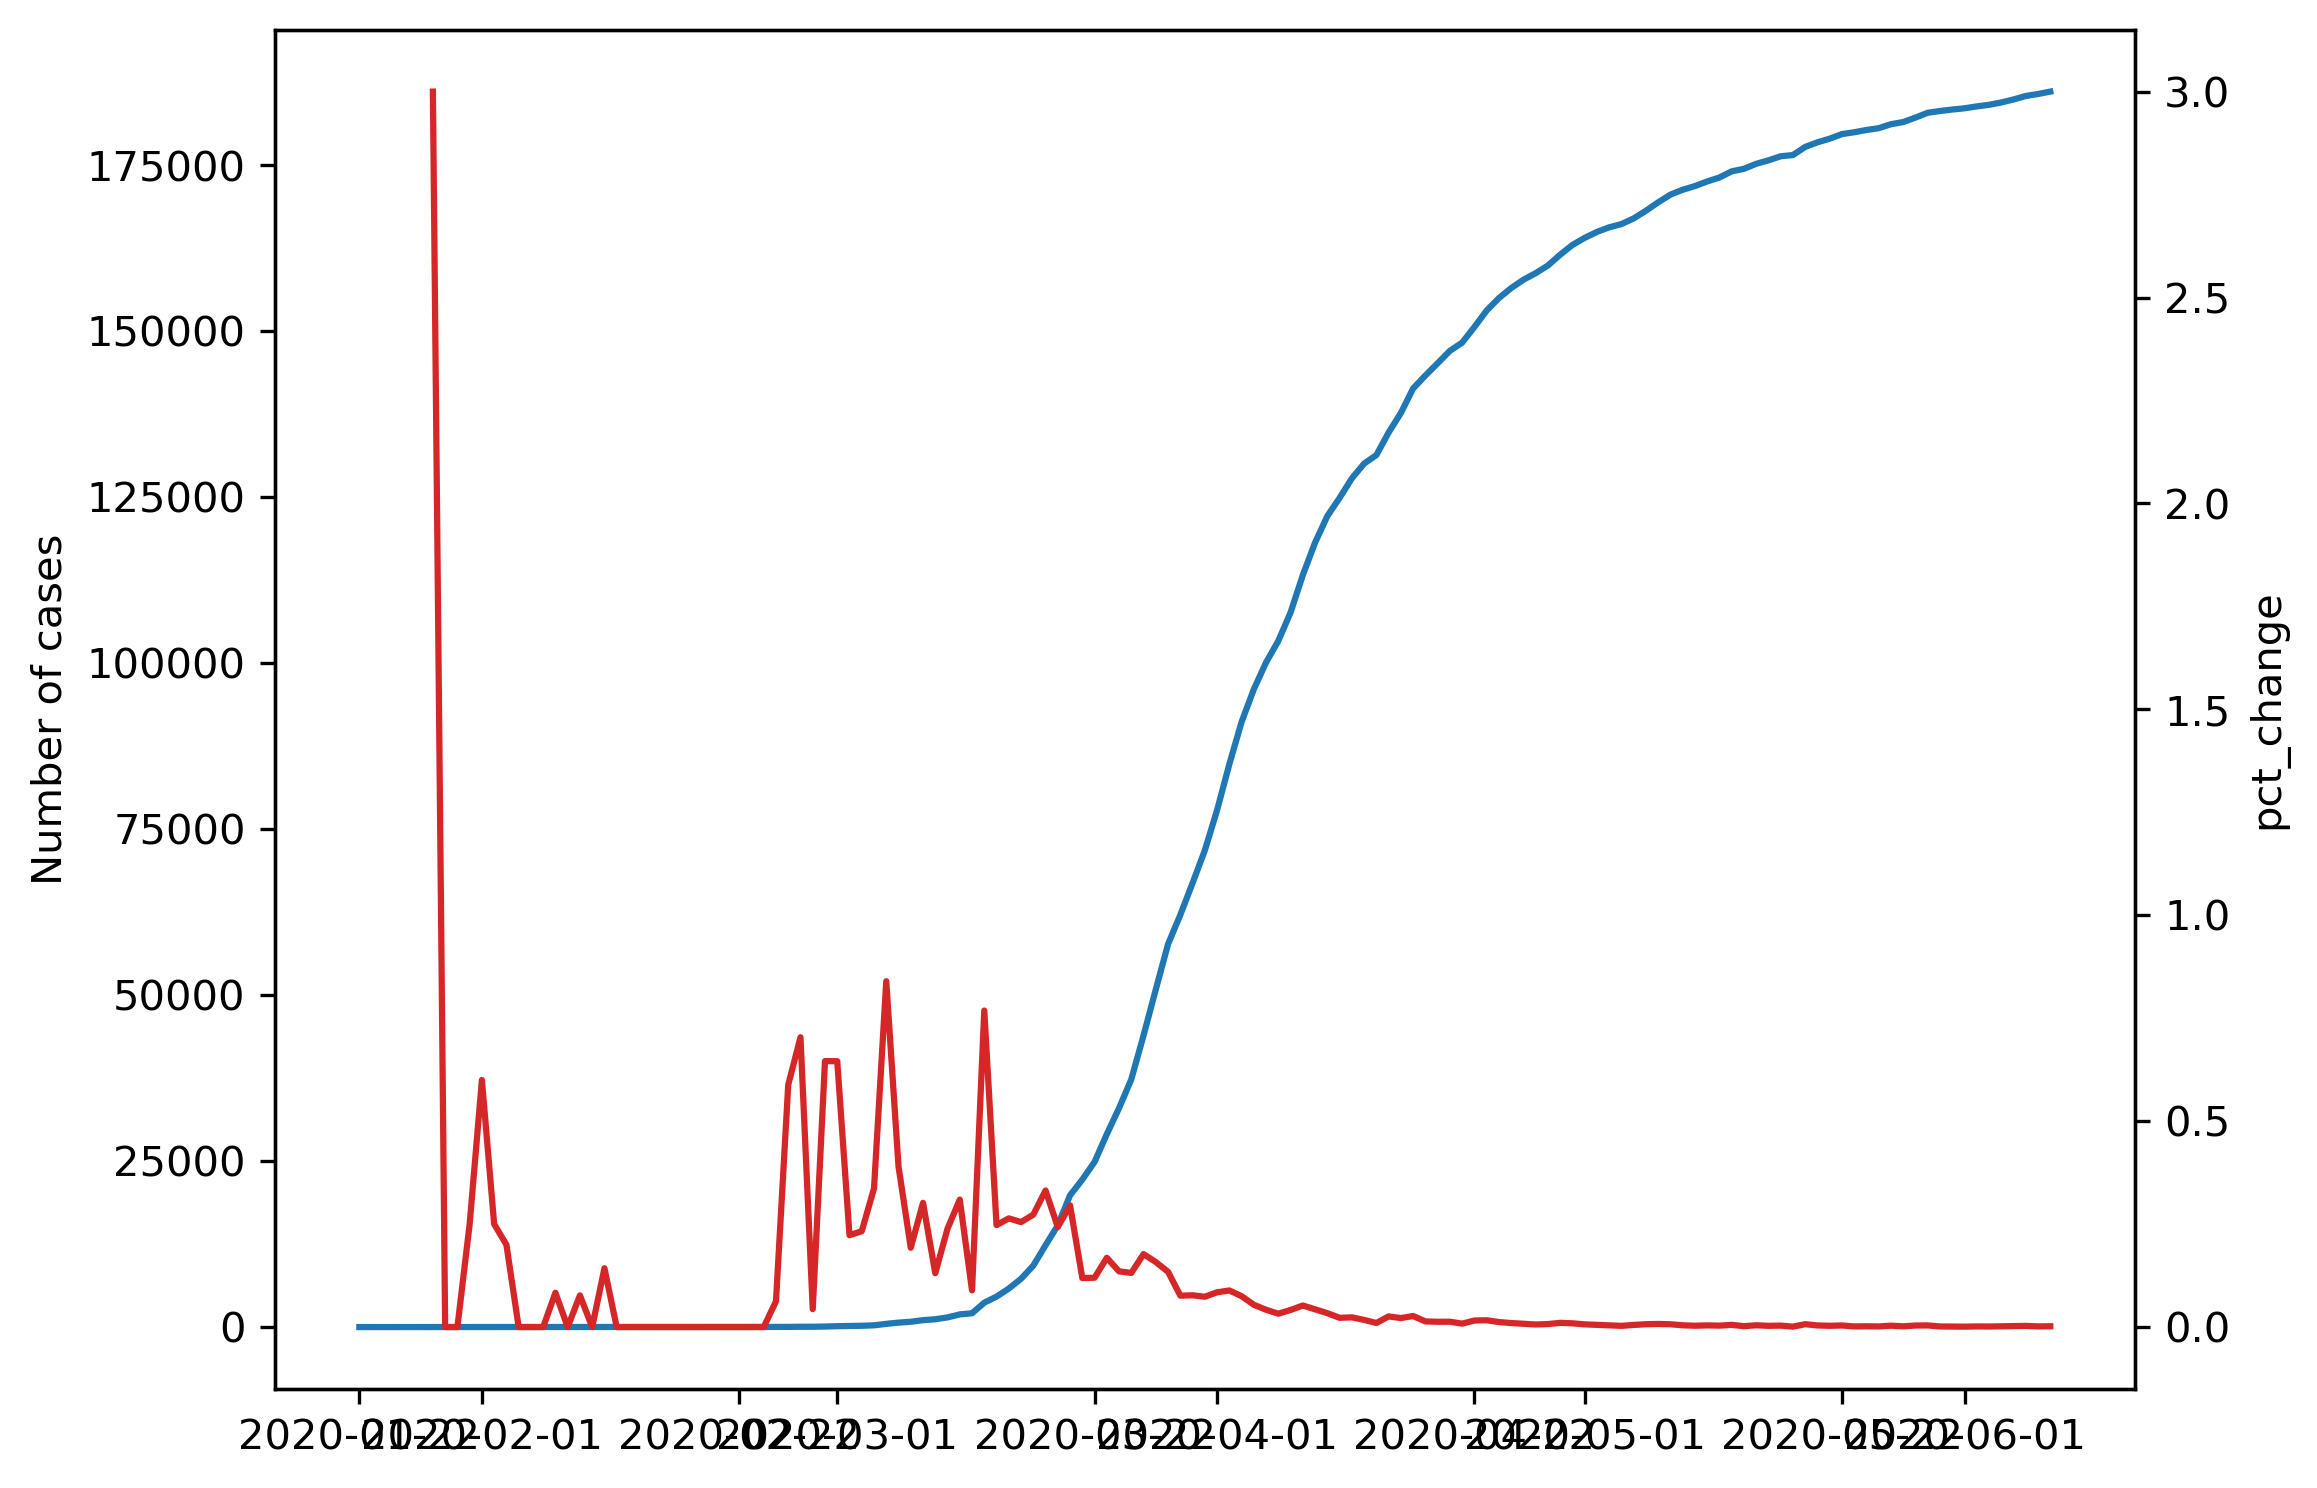

In [24]:
cases_and_rate(df_by_country['Germany'])

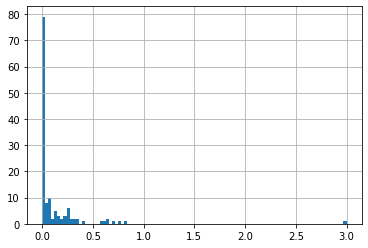

In [25]:
(df_by_country['Germany'].pct_change()
 .dropna()
 .replace([np.inf, -np.inf], np.nan)
 .hist(bins=100)
)

## United States

In [26]:
df_by_country.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
       ...
       'United Kingdom', 'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam',
       'West Bank and Gaza', 'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Country/Region', length=188)

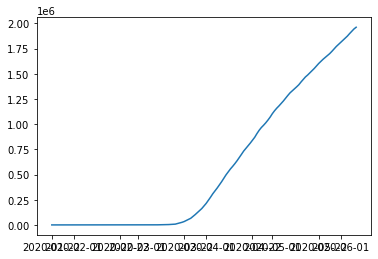

In [27]:
df_by_country['US'].plot()

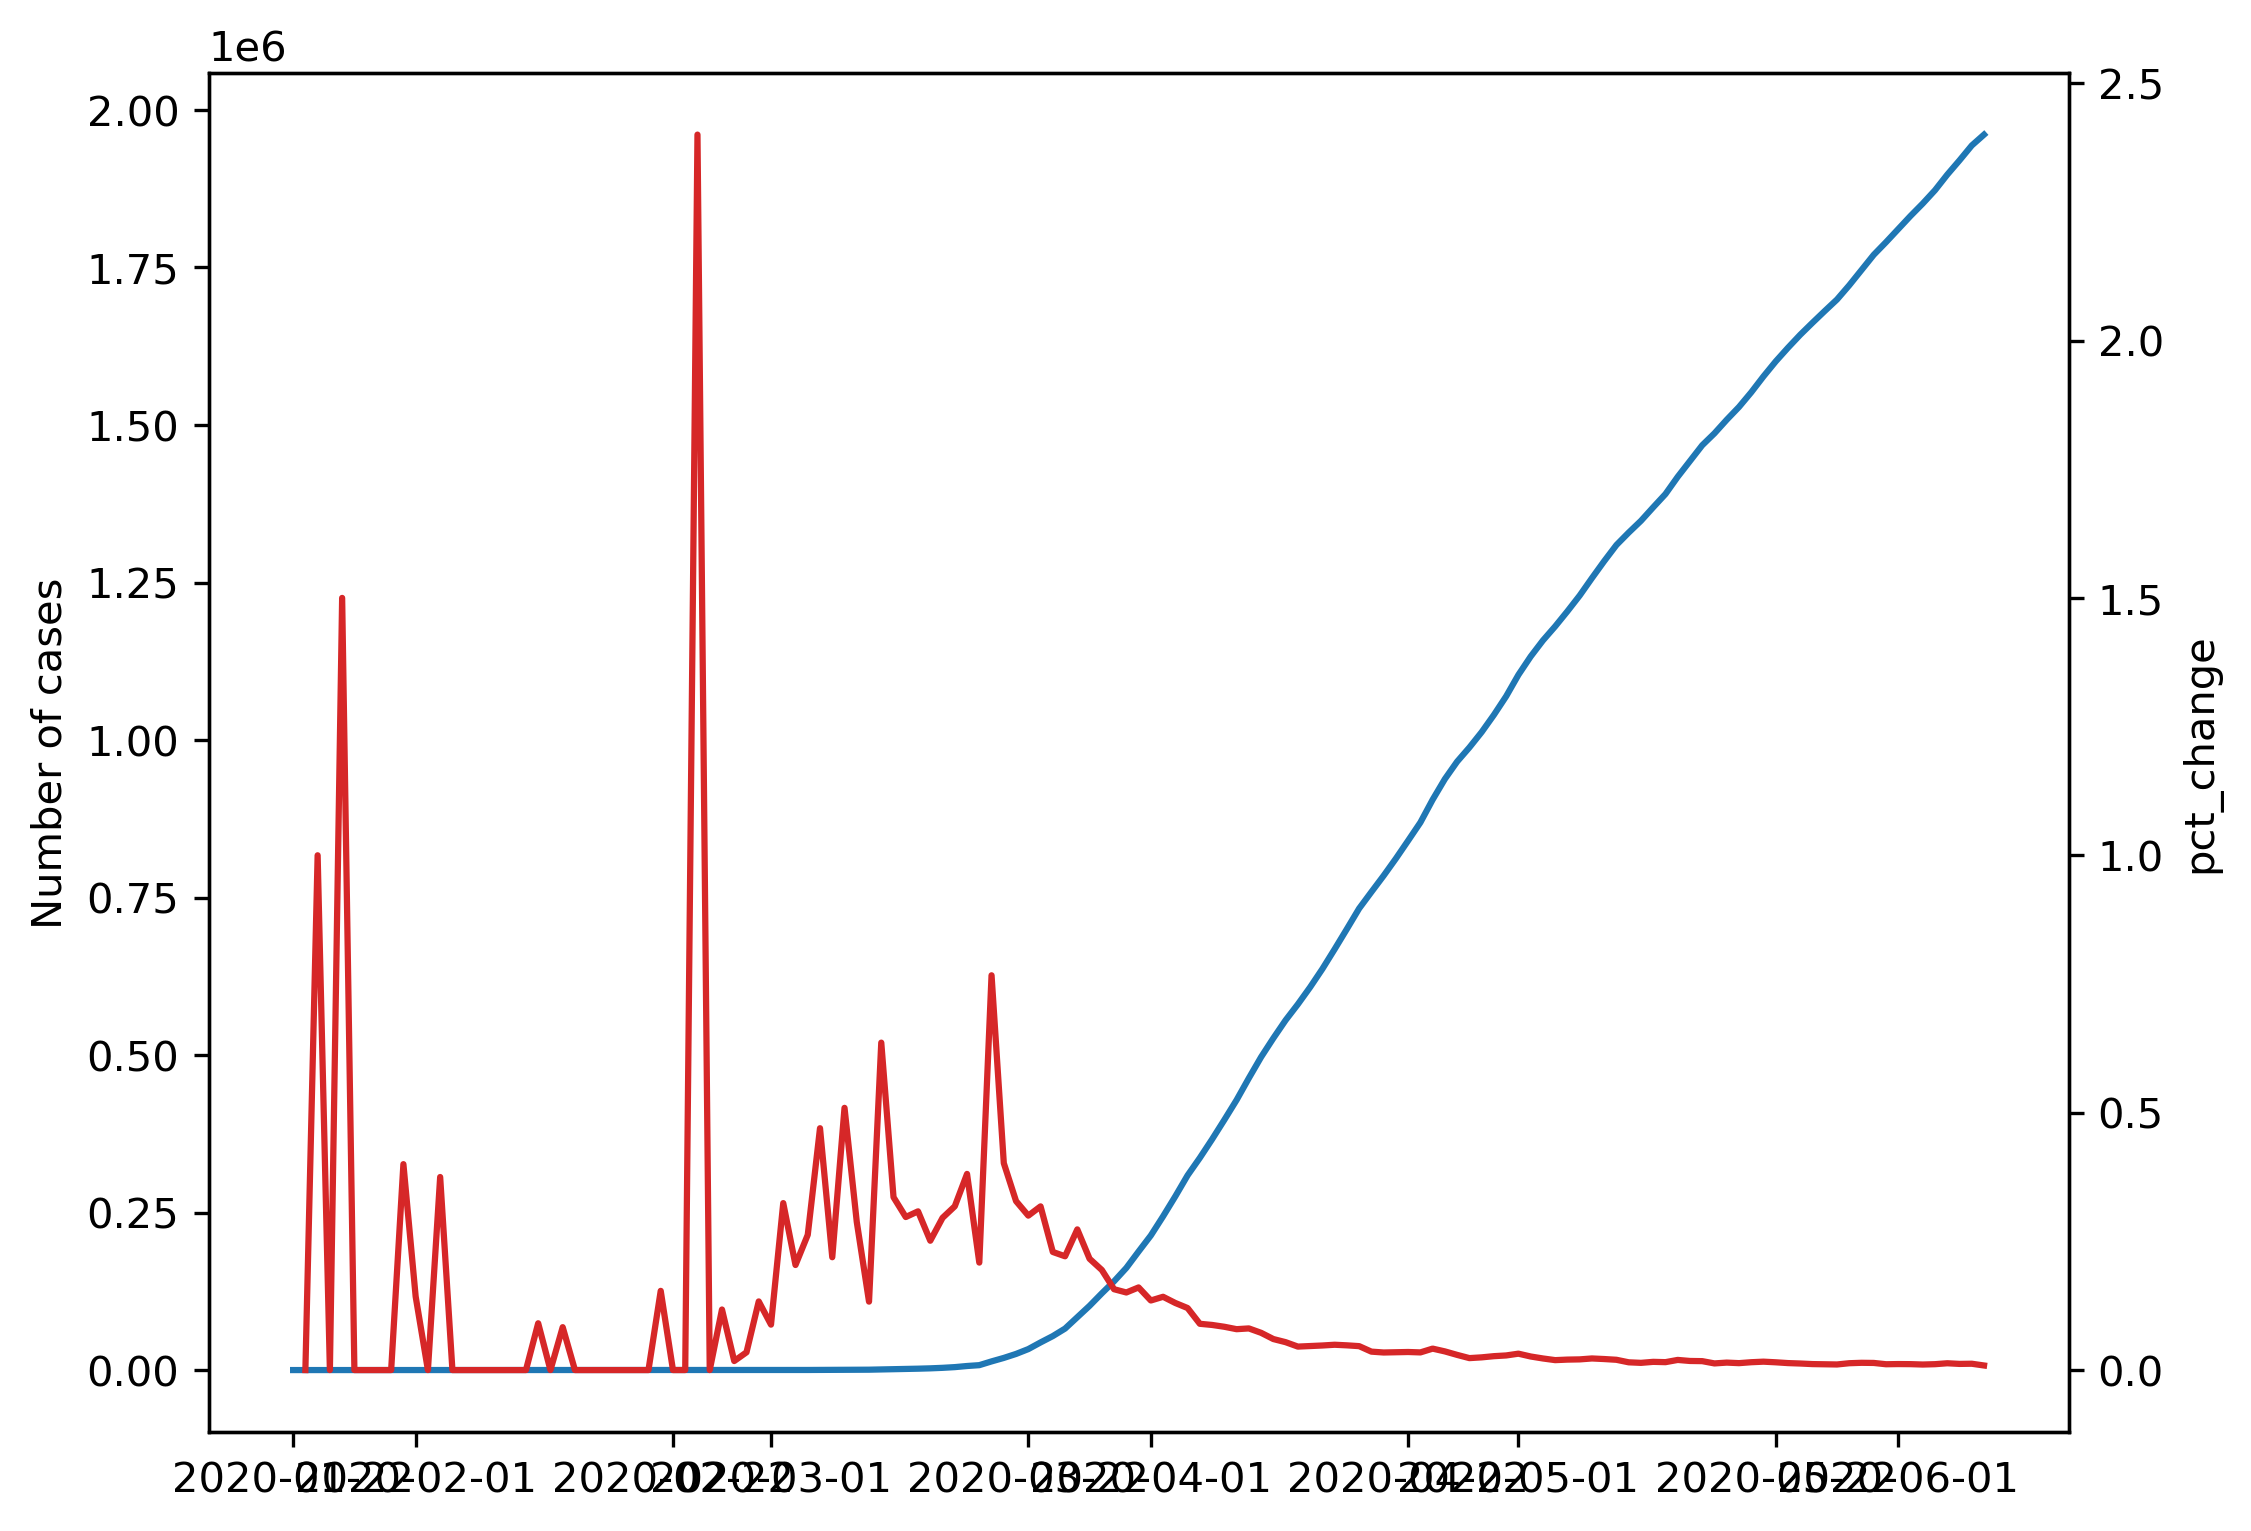

In [28]:
cases_and_rate(df_by_country['US'])

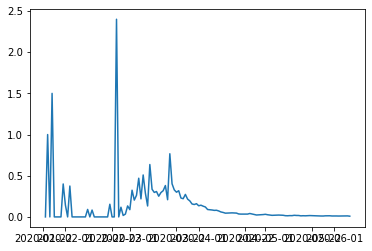

In [29]:
df_by_country['US'].pct_change().plot()

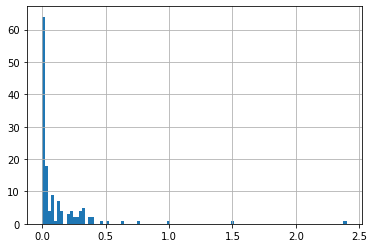

In [30]:
df_by_country['US'].pct_change().hist(bins=100)

## Italy

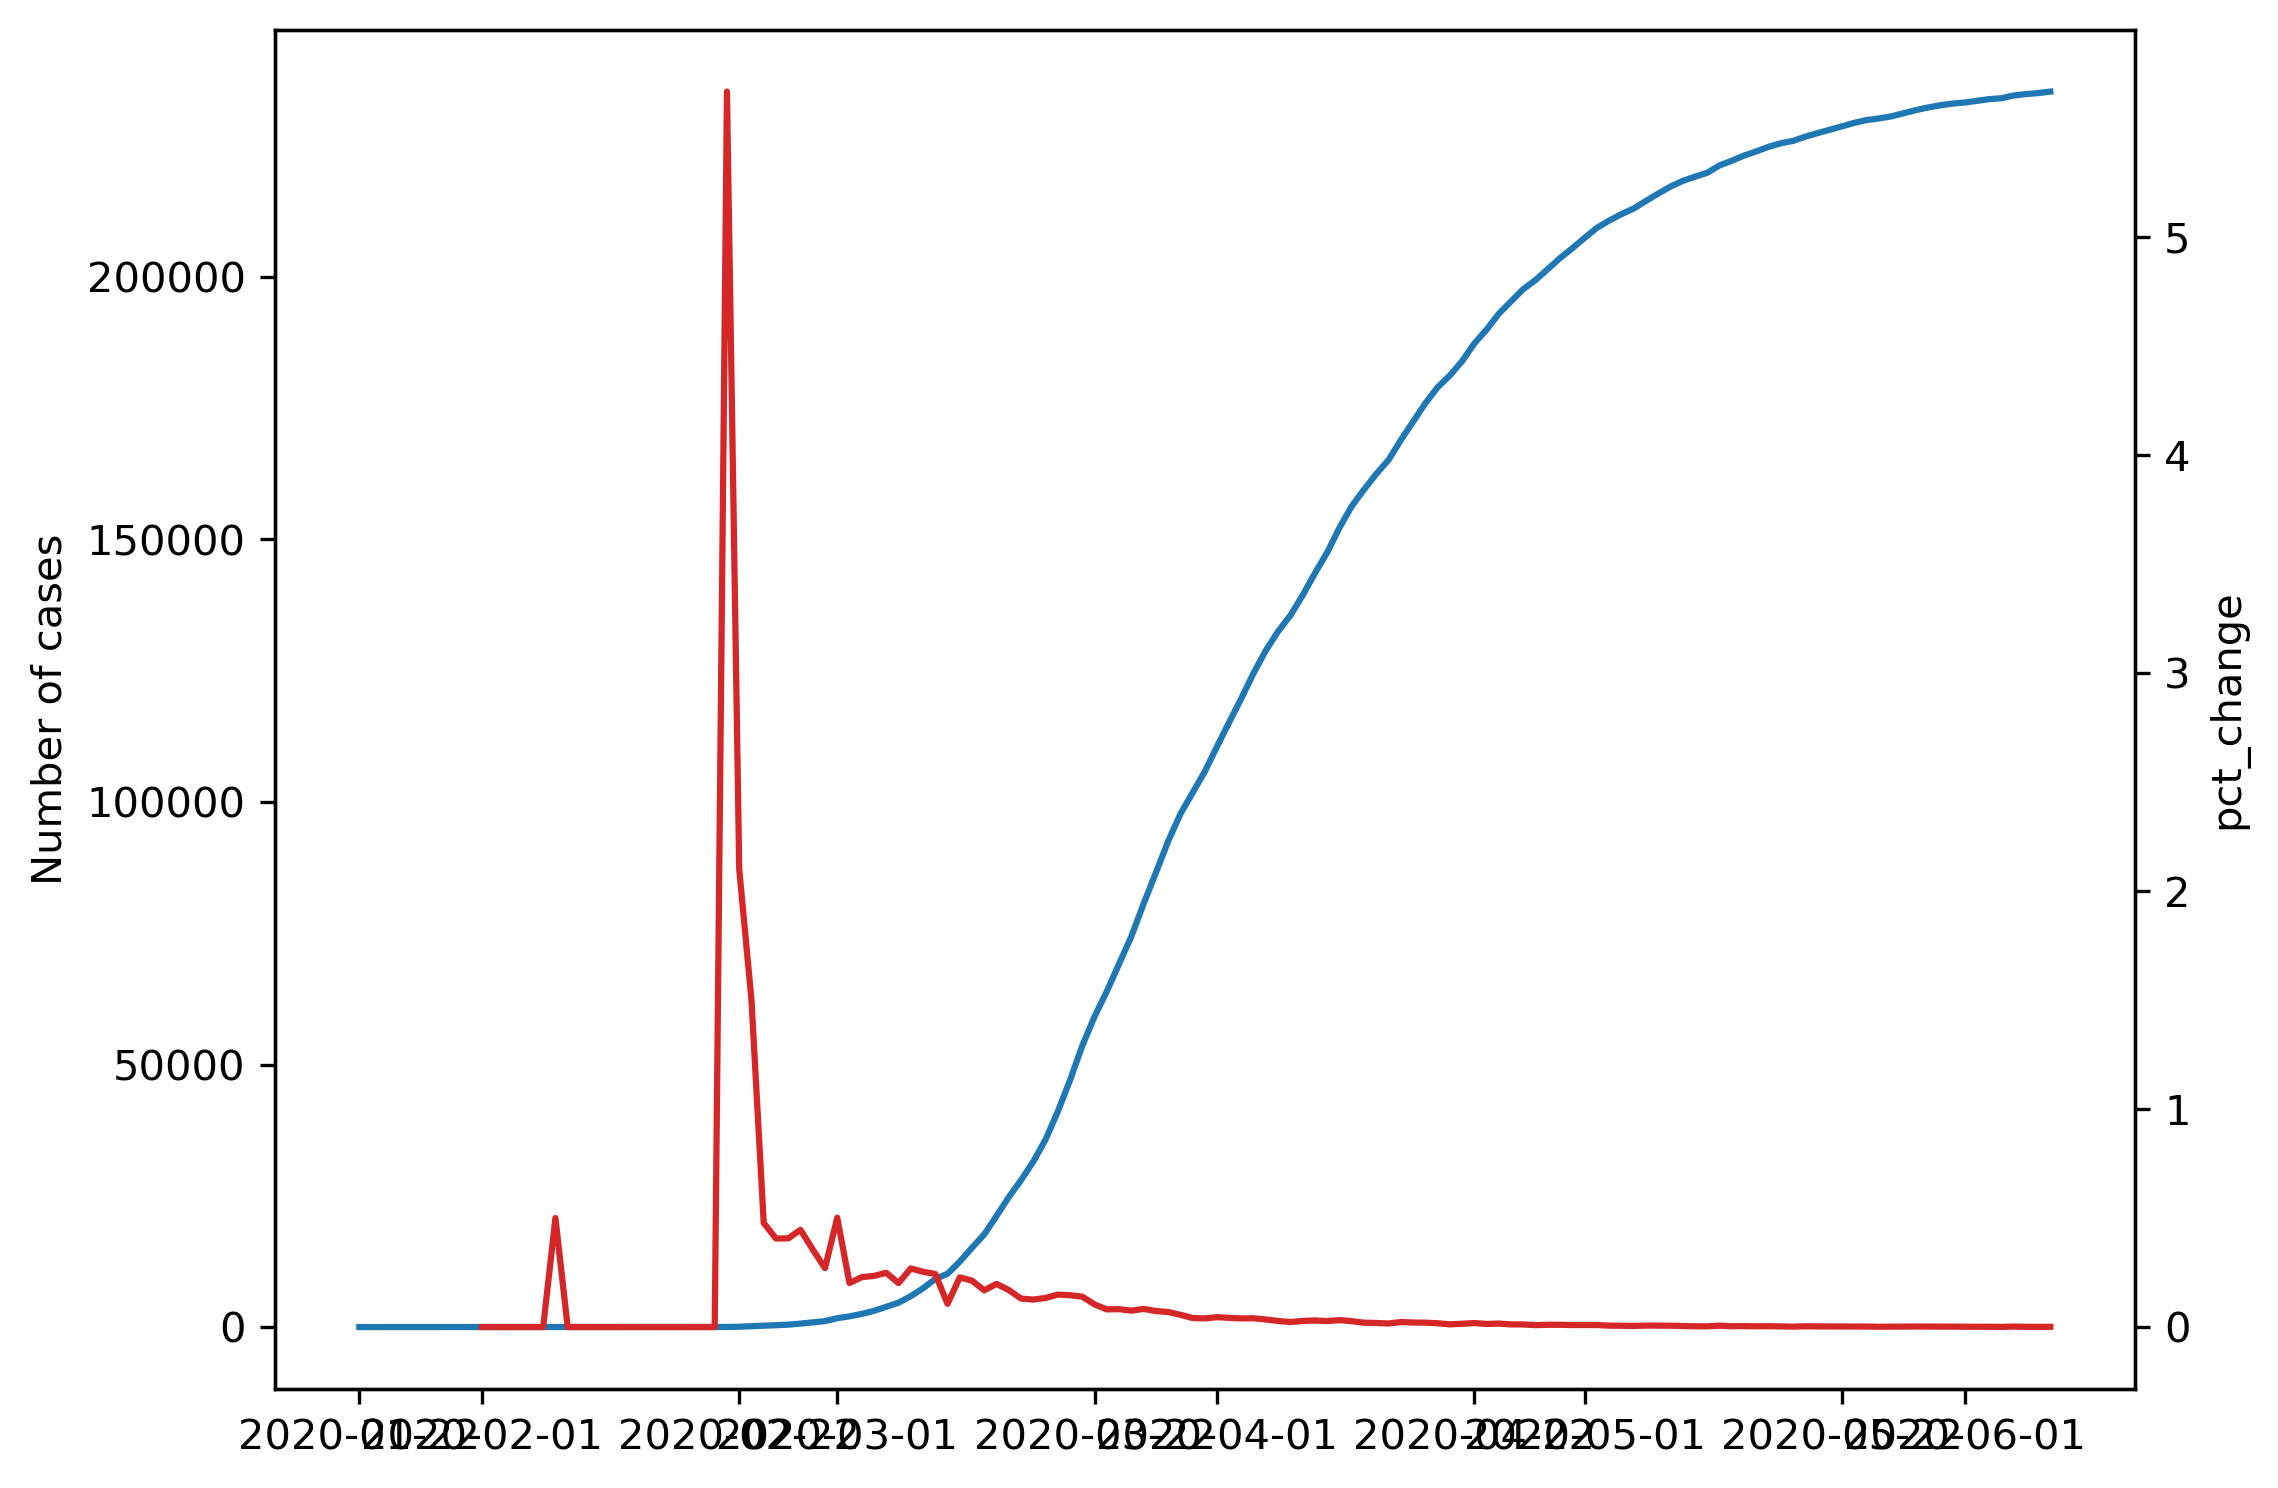

In [31]:
cases_and_rate(df_by_country['Italy'])

## Sweden
Of interest as a country that has not imposed any lockdown measures.

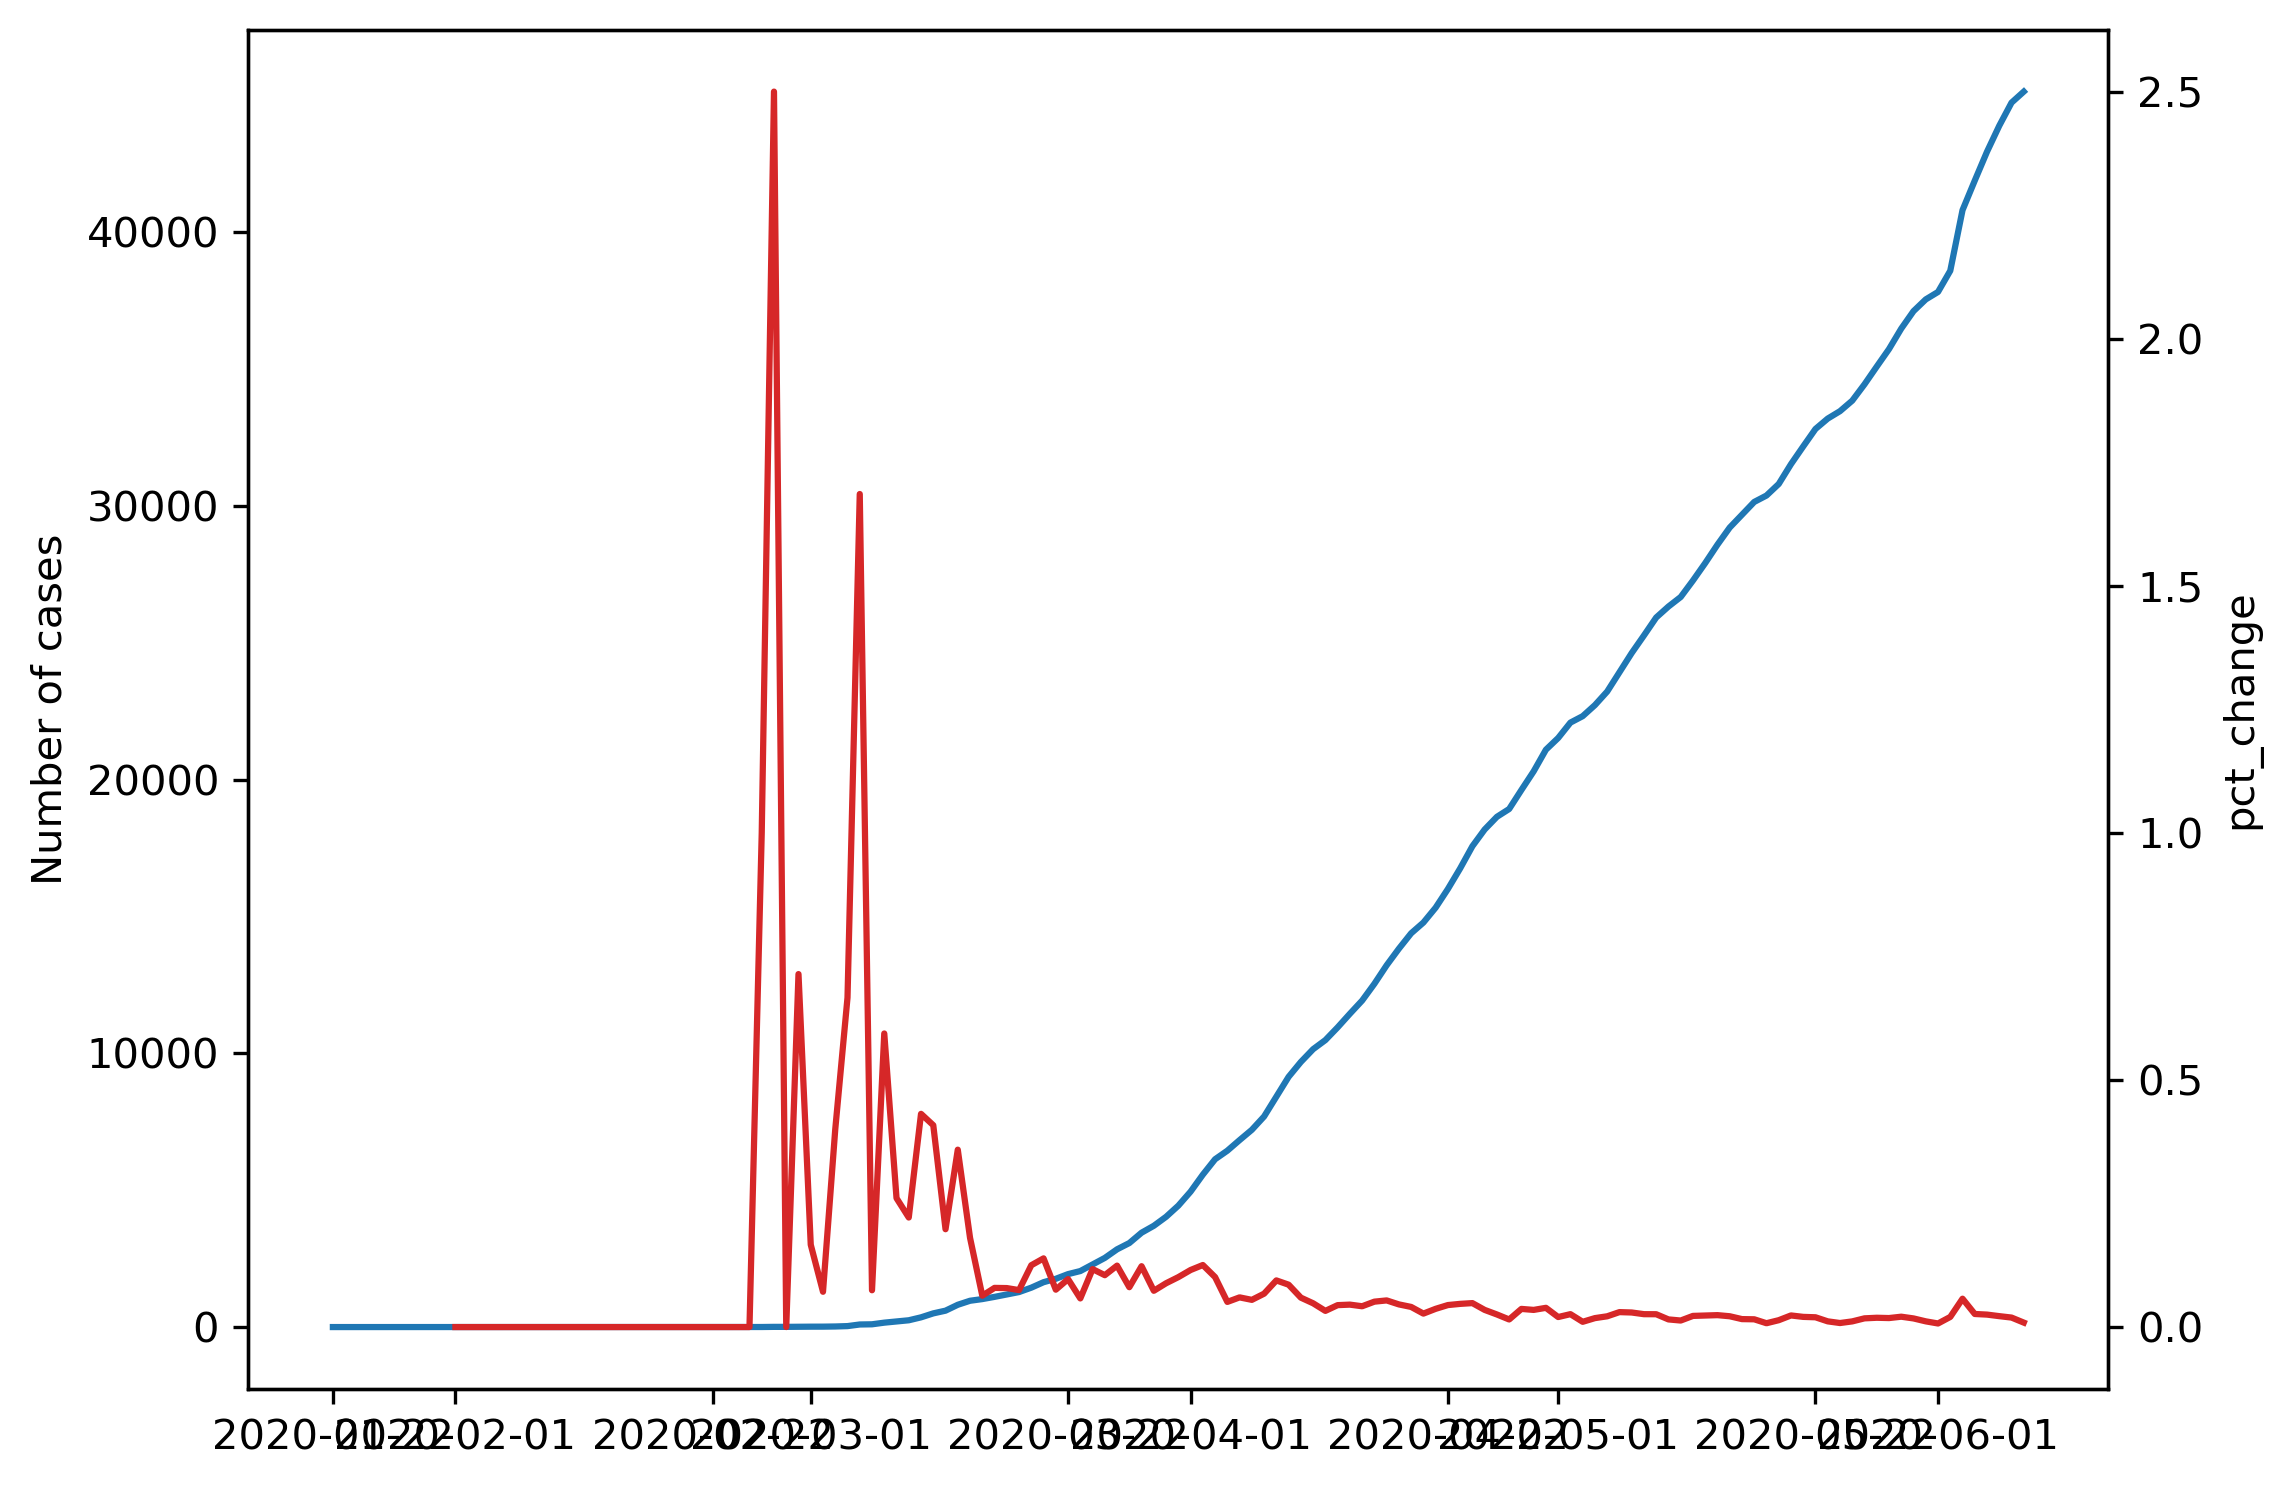

In [32]:
cases_and_rate(df_by_country['Sweden'])

## New Zealand

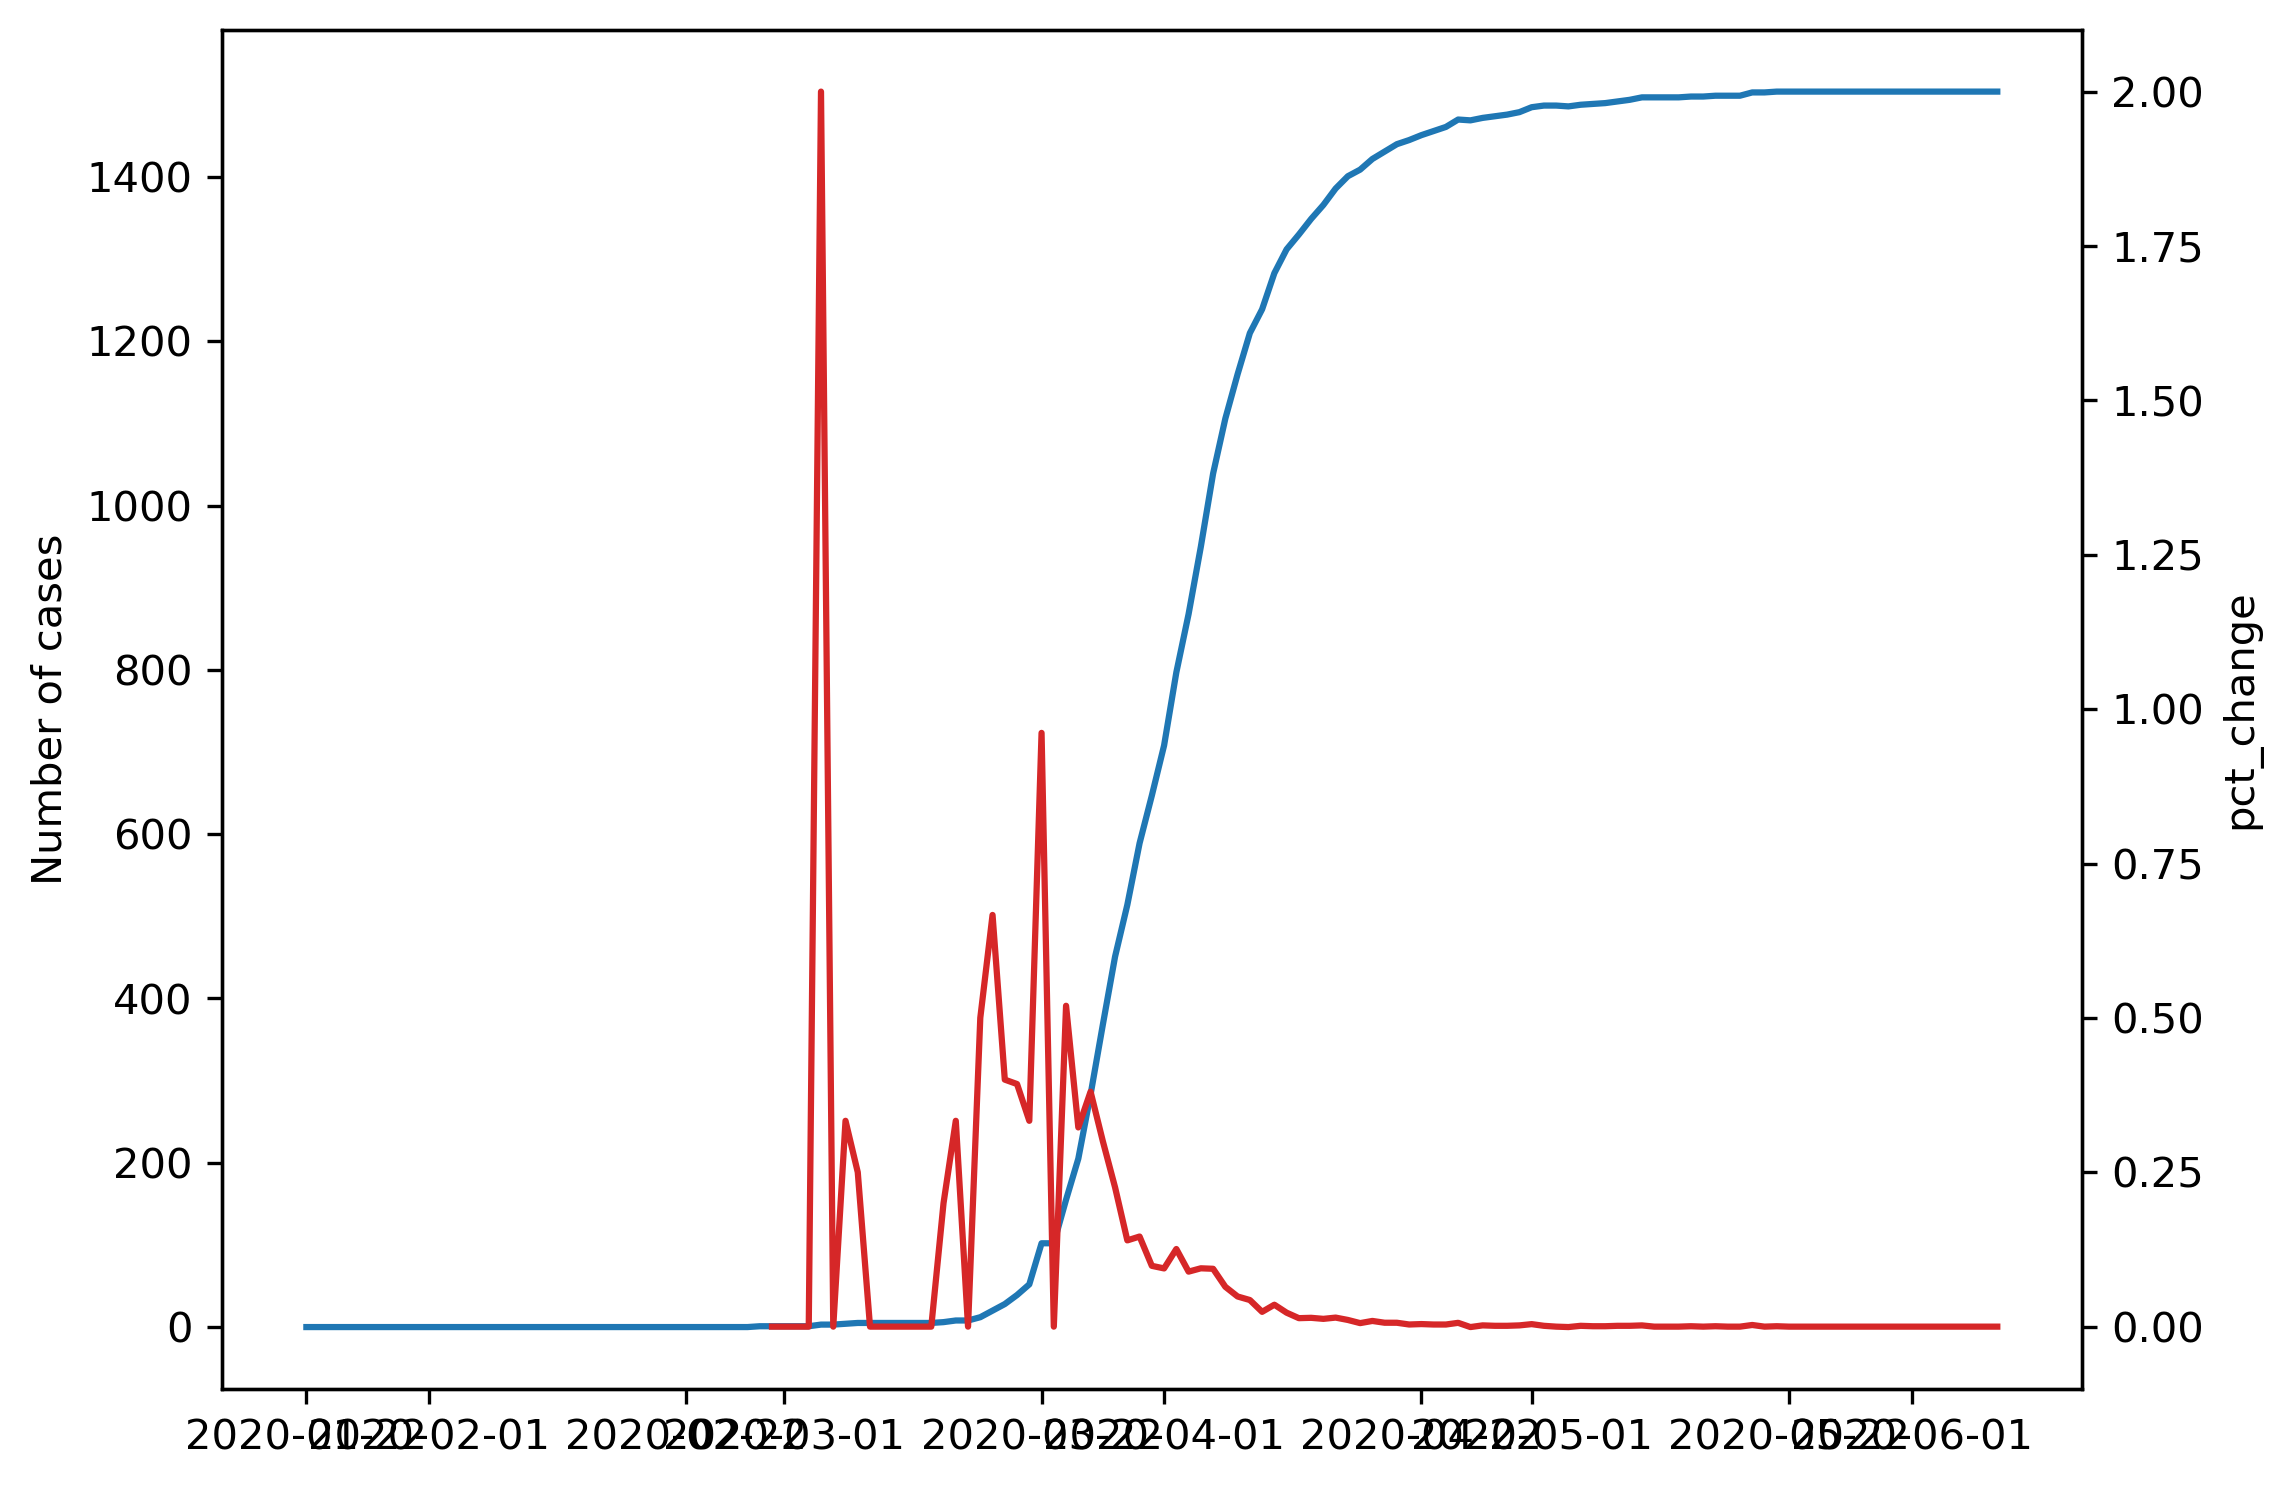

In [33]:
cases_and_rate(df_by_country['New Zealand'])

## Brazil

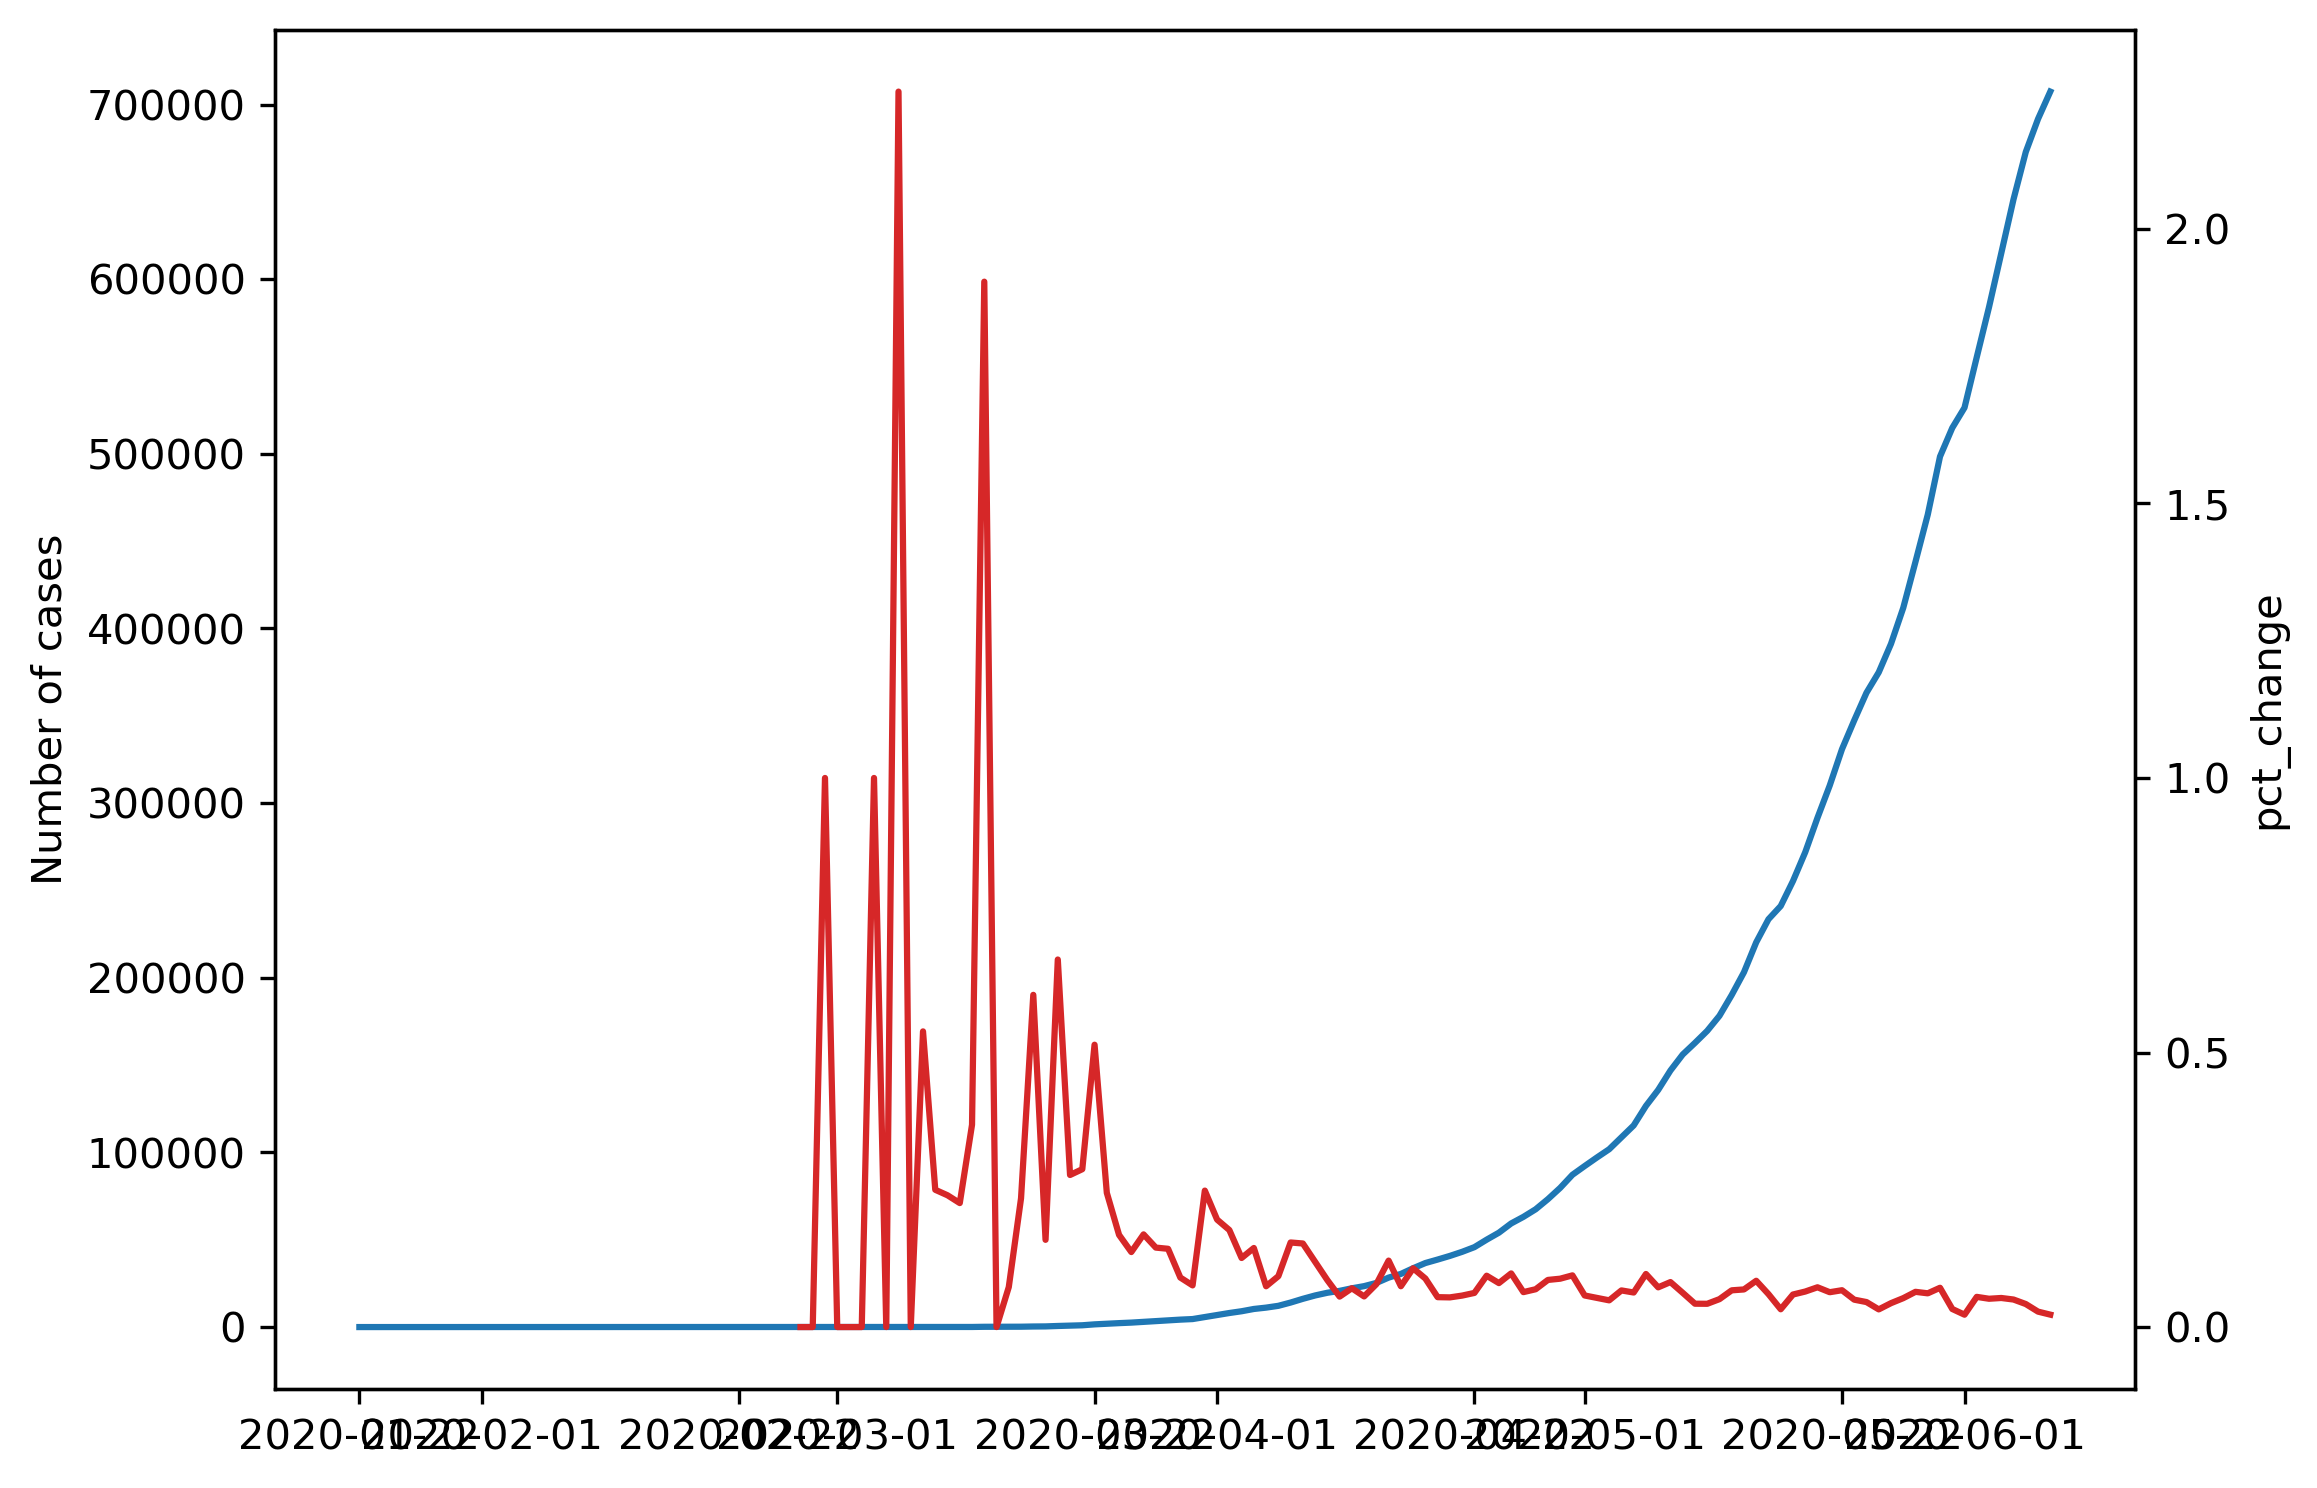

In [34]:
cases_and_rate(df_by_country['Brazil'])

## Exploring change rates

### Checking where a appropriate cutoff for visualising change rates is

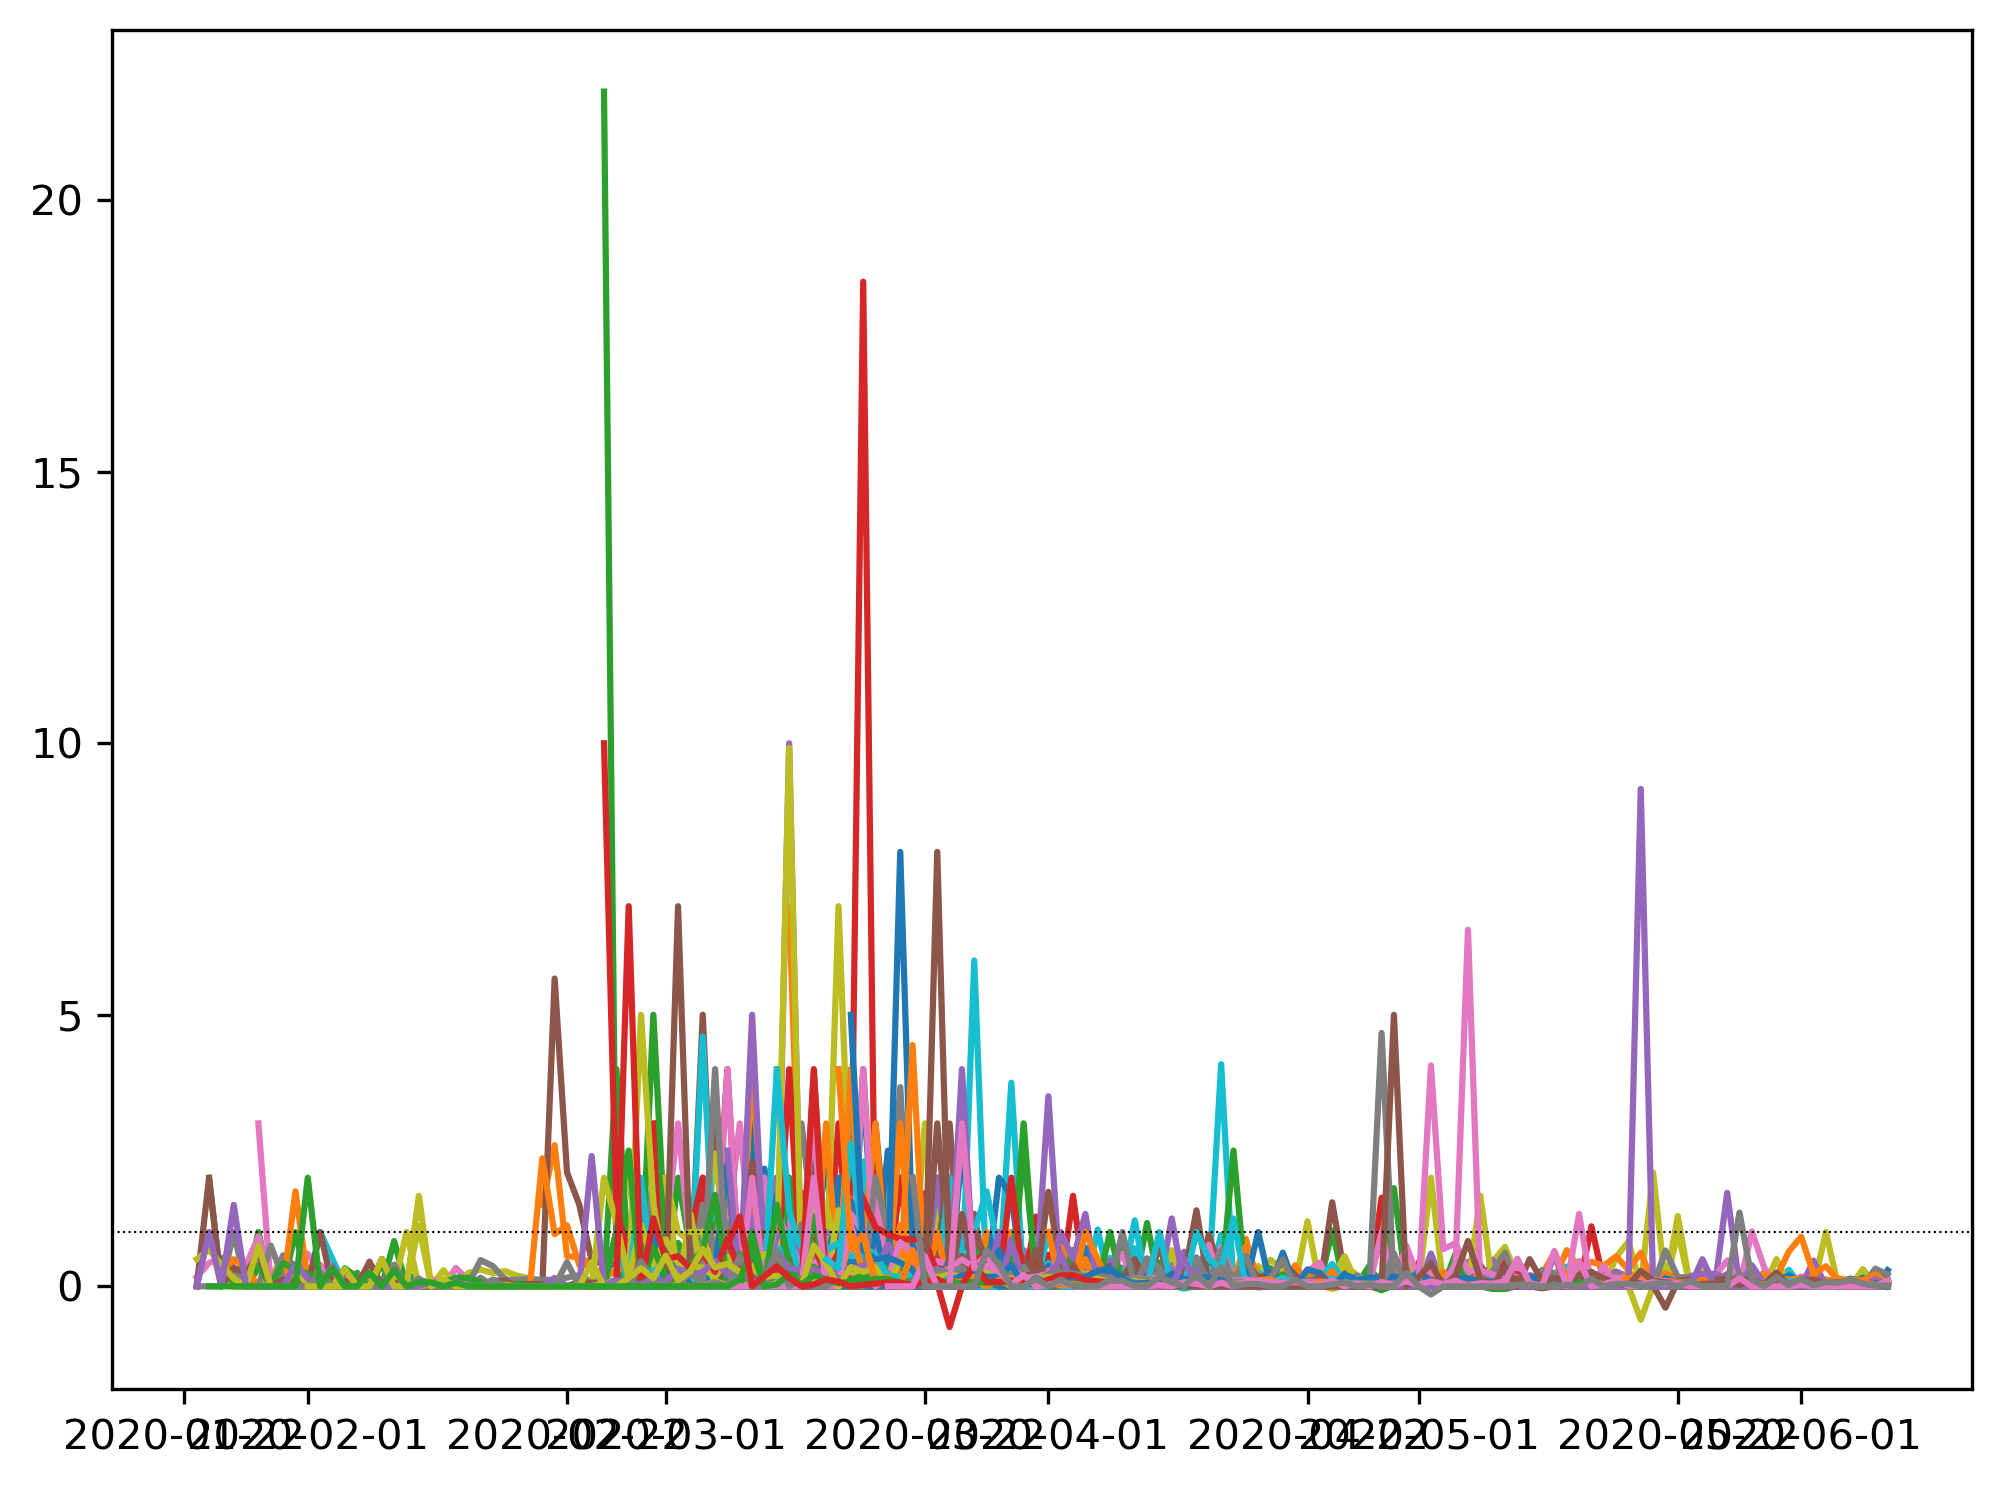

In [35]:
pct_fig, pct_ax = plt.subplots(figsize=(8,6), dpi=300)
pct_ax.plot(df_by_country.pct_change())
pct_ax.axhline(y=1, color="black", linestyle=":", linewidth=".5")

The key observation from the above graph is that percentage changes above 100% are usually an artifact of low case numbers, and cases before this time (at least) should be filtered out.

In [36]:
df_by_country.pct_change() > 1

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22            False    False    False    False   False   
2020-01-23            False    False    False    False   False   
2020-01-24            False    False    False    False   False   
2020-01-25            False    False    False    False   False   
2020-01-26            False    False    False    False   False   
...                     ...      ...      ...      ...     ...   
2020-06-04            False    False    False    False   False   
2020-06-05            False    False    False    False   False   
2020-06-06            False    False    False    False   False   
2020-06-07            False    False    False    False   False   
2020-06-08            False    False    False    False   False   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                    False      False    False      False    False   
2020-01-23                    False      False    False      False    False   
2020-01-24                    False      False    False      False    False   
2020-01-25                    False      False    False      False    False   
2020-01-26                    False      False    False       True    False   
...                             ...        ...      ...        ...      ...   
2020-06-04                    False      False    False      False    False   
2020-06-05                    False      False    False      False    False   
2020-06-06                    False      False    False      False    False   
2020-06-07                    False      False    False      False    False   
2020-06-08                    False      False    False      False    False   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...           False    False       False      False    False   
2020-01-23      ...           False    False       False      False     True   
2020-01-24      ...           False    False       False      False    False   
2020-01-25      ...           False    False       False      False    False   
2020-01-26      ...           False    False       False      False    False   
...             ...             ...      ...         ...        ...      ...   
2020-06-04      ...           False    False       False      False    False   
2020-06-05      ...           False    False       False      False    False   
2020-06-06      ...           False    False       False      False    False   
2020-06-07      ...           False    False       False      False    False   
2020-06-08      ...           False    False       False      False    False   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                   False           False  False   False     False  
2020-01-23                   False           False  False   False     False  
2020-01-24                   False           False  False   False     False  
2020-01-25                   False           False  False   False     False  
2020-01-26                   False           False  False   False     False  
...                            ...             ...    ...     ...       ...  
2020-06-04                   False           False  False   False     False  
2020-06-05                   False           False  False   False     False  
2020-06-06                   False           False  False   False     False  
2020-06-07                   False           False  False   False     False  
2020-06-08                   False           False  False   False     False  

[139 rows x 188 columns]

In [37]:
df_by_country[df_by_country.pct_change() > 1]

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
2020-01-22              NaN      NaN      NaN      NaN     NaN   
2020-01-23              NaN      NaN      NaN      NaN     NaN   
2020-01-24              NaN      NaN      NaN      NaN     NaN   
2020-01-25              NaN      NaN      NaN      NaN     NaN   
2020-01-26              NaN      NaN      NaN      NaN     NaN   
...                     ...      ...      ...      ...     ...   
2020-06-04              NaN      NaN      NaN      NaN     NaN   
2020-06-05              NaN      NaN      NaN      NaN     NaN   
2020-06-06              NaN      NaN      NaN      NaN     NaN   
2020-06-07              NaN      NaN      NaN      NaN     NaN   
2020-06-08              NaN      NaN      NaN      NaN     NaN   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
2020-01-22                      NaN        NaN      NaN        NaN      NaN   
2020-01-23                      NaN        NaN      NaN        NaN      NaN   
2020-01-24                      NaN        NaN      NaN        NaN      NaN   
2020-01-25                      NaN        NaN      NaN        NaN      NaN   
2020-01-26                      NaN        NaN      NaN        4.0      NaN   
...                             ...        ...      ...        ...      ...   
2020-06-04                      NaN        NaN      NaN        NaN      NaN   
2020-06-05                      NaN        NaN      NaN        NaN      NaN   
2020-06-06                      NaN        NaN      NaN        NaN      NaN   
2020-06-07                      NaN        NaN      NaN        NaN      NaN   
2020-06-08                      NaN        NaN      NaN        NaN      NaN   

Country/Region  ...  United Kingdom  Uruguay  Uzbekistan  Venezuela  Vietnam  \
2020-01-22      ...             NaN      NaN         NaN        NaN      NaN   
2020-01-23      ...             NaN      NaN         NaN        NaN      2.0   
2020-01-24      ...             NaN      NaN         NaN        NaN      NaN   
2020-01-25      ...             NaN      NaN         NaN        NaN      NaN   
2020-01-26      ...             NaN      NaN         NaN        NaN      NaN   
...             ...             ...      ...         ...        ...      ...   
2020-06-04      ...             NaN      NaN         NaN        NaN      NaN   
2020-06-05      ...             NaN      NaN         NaN        NaN      NaN   
2020-06-06      ...             NaN      NaN         NaN        NaN      NaN   
2020-06-07      ...             NaN      NaN         NaN        NaN      NaN   
2020-06-08      ...             NaN      NaN         NaN        NaN      NaN   

Country/Region  West Bank and Gaza  Western Sahara  Yemen  Zambia  Zimbabwe  
2020-01-22                     NaN             NaN    NaN     NaN       NaN  
2020-01-23                     NaN             NaN    NaN     NaN       NaN  
2020-01-24                     NaN             NaN    NaN     NaN       NaN  
2020-01-25                     NaN             NaN    NaN     NaN       NaN  
2020-01-26                     NaN             NaN    NaN     NaN       NaN  
...                            ...             ...    ...     ...       ...  
2020-06-04                     NaN             NaN    NaN     NaN       NaN  
2020-06-05                     NaN             NaN    NaN     NaN       NaN  
2020-06-06                     NaN             NaN    NaN     NaN       NaN  
2020-06-07                     NaN             NaN    NaN     NaN       NaN  
2020-06-08                     NaN             NaN    NaN     NaN       NaN  

[139 rows x 188 columns]

In [38]:
df_by_country['Sweden'][df_by_country['Sweden'].pct_change() > 1].index[-1]

datetime.date(2020, 3, 5)

In [39]:
def get_last_date_crossed(series, threshold):
    try:
        result = series[series.pct_change() > threshold].index[-1]
        return result
    except IndexError:
        return np.nan

In [40]:
def get_last_date_crossed_1(series):
    return get_last_date_crossed(series, 1)

In [41]:
dates_last_crossed_1 = df_by_country.apply(func=get_last_date_crossed_1).dropna()
dates_last_crossed_1

Country/Region
Afghanistan           2020-03-08
Albania               2020-03-10
Algeria               2020-03-04
Andorra               2020-03-17
Angola                2020-03-20
                         ...    
West Bank and Gaza    2020-03-07
Western Sahara        2020-04-05
Yemen                 2020-04-29
Zambia                2020-03-25
Zimbabwe              2020-05-27
Length: 185, dtype: object

According to this result, as of currently run period, 3 countries ($185 - 182 = 3$) have not crossed 100% increase in cases yet.

Next, we take a look at which countries this may be.

In [42]:
set(df_by_country.columns) - set(dates_last_crossed_1.index)

{'China', 'Japan', 'Thailand'}

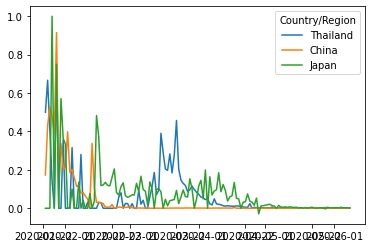

In [43]:
df_by_country[set(df_by_country.columns) - set(dates_last_crossed_1.index)].pct_change().plot()

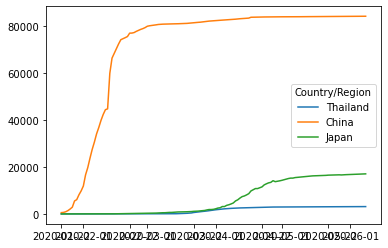

In [44]:
df_by_country[set(df_by_country.columns) - set(dates_last_crossed_1.index)].plot()

This suggests a problem with the function, since these three countries have had cases, but have never crossed 100% increases in case count throughout their history. This suggests that the threshold should be lowered.

In [45]:
df_by_country['Thailand'].pct_change().max()

0.75

In [46]:
def get_last_date_crossed_07499(series):
    return get_last_date_crossed(series, .7499)

In [47]:
dates_last_crossed_07499 = df_by_country.apply(func=get_last_date_crossed_07499).dropna()
dates_last_crossed_07499

Country/Region
Afghanistan           2020-03-24
Albania               2020-03-12
Algeria               2020-03-04
Andorra               2020-03-17
Angola                2020-03-21
                         ...    
West Bank and Gaza    2020-03-07
Western Sahara        2020-04-05
Yemen                 2020-05-05
Zambia                2020-03-25
Zimbabwe              2020-05-27
Length: 188, dtype: object

In [48]:
df_by_country['Afghanistan'][dt.date(2020, 3, 8)]

4

In [49]:
for i in dates_last_crossed_07499.index:
    print(f"Country: {i}, Date: {dates_last_crossed_07499[i]}, Case Count: {df_by_country[i][dates_last_crossed_07499[i]]}")

Country: Afghanistan, Date: 2020-03-24, Case Count: 74
Country: Albania, Date: 2020-03-12, Case Count: 23
Country: Algeria, Date: 2020-03-04, Case Count: 12
Country: Andorra, Date: 2020-03-17, Case Count: 39
Country: Angola, Date: 2020-03-21, Case Count: 2
Country: Antigua and Barbuda, Date: 2020-03-26, Case Count: 7
Country: Argentina, Date: 2020-03-07, Case Count: 8
Country: Armenia, Date: 2020-03-16, Case Count: 52
Country: Australia, Date: 2020-01-26, Case Count: 4
Country: Austria, Date: 2020-02-29, Case Count: 9
Country: Azerbaijan, Date: 2020-03-05, Case Count: 6
Country: Bahamas, Date: 2020-03-26, Case Count: 9
Country: Bahrain, Date: 2020-03-11, Case Count: 195
Country: Bangladesh, Date: 2020-03-08, Case Count: 3
Country: Barbados, Date: 2020-03-22, Case Count: 14
Country: Belarus, Date: 2020-04-02, Case Count: 304
Country: Belgium, Date: 2020-03-13, Case Count: 559
Country: Belize, Date: 2020-03-25, Case Count: 2
Country: Benin, Date: 2020-03-23, Case Count: 5
Country: Bhutan

In [50]:
last_crossed_07499 = dates_last_crossed_07499.to_frame(name='Date')
last_crossed_07499['Case Count'] = [df_by_country[x][dates_last_crossed_07499[x]] for x in dates_last_crossed_07499.index]
last_crossed_07499

Date  Case Count
Country/Region                            
Afghanistan         2020-03-24          74
Albania             2020-03-12          23
Algeria             2020-03-04          12
Andorra             2020-03-17          39
Angola              2020-03-21           2
...                        ...         ...
West Bank and Gaza  2020-03-07          16
Western Sahara      2020-04-05           4
Yemen               2020-05-05          22
Zambia              2020-03-25          12
Zimbabwe            2020-05-27         132

[188 rows x 2 columns]

In [51]:
last_crossed_07499.describe()

Case Count
count    188.000000
mean     356.042553
std     2020.408896
min        2.000000
25%        8.000000
50%       22.000000
75%       83.000000
max    22719.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ec51a8bb0>]],
      dtype=object)

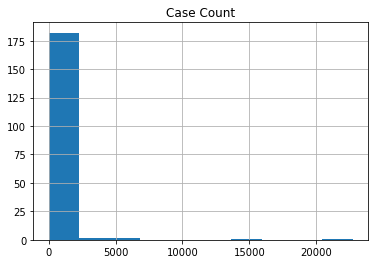

In [52]:
last_crossed_07499.hist()

In [53]:
last_crossed_07499.sort_values(by='Case Count')

Date  Case Count
Country/Region                                
Bosnia and Herzegovina  2020-03-05           2
Fiji                    2020-03-22           2
Angola                  2020-03-21           2
Mauritania              2020-03-19           2
Bhutan                  2020-03-20           2
...                            ...         ...
Germany                 2020-03-13        3675
Spain                   2020-03-13        5232
China                   2020-01-28        5509
US                      2020-03-19       13748
Ecuador                 2020-04-24       22719

[188 rows x 2 columns]

Ecuador has an alarmingly high case count for the most recent 100% change day.

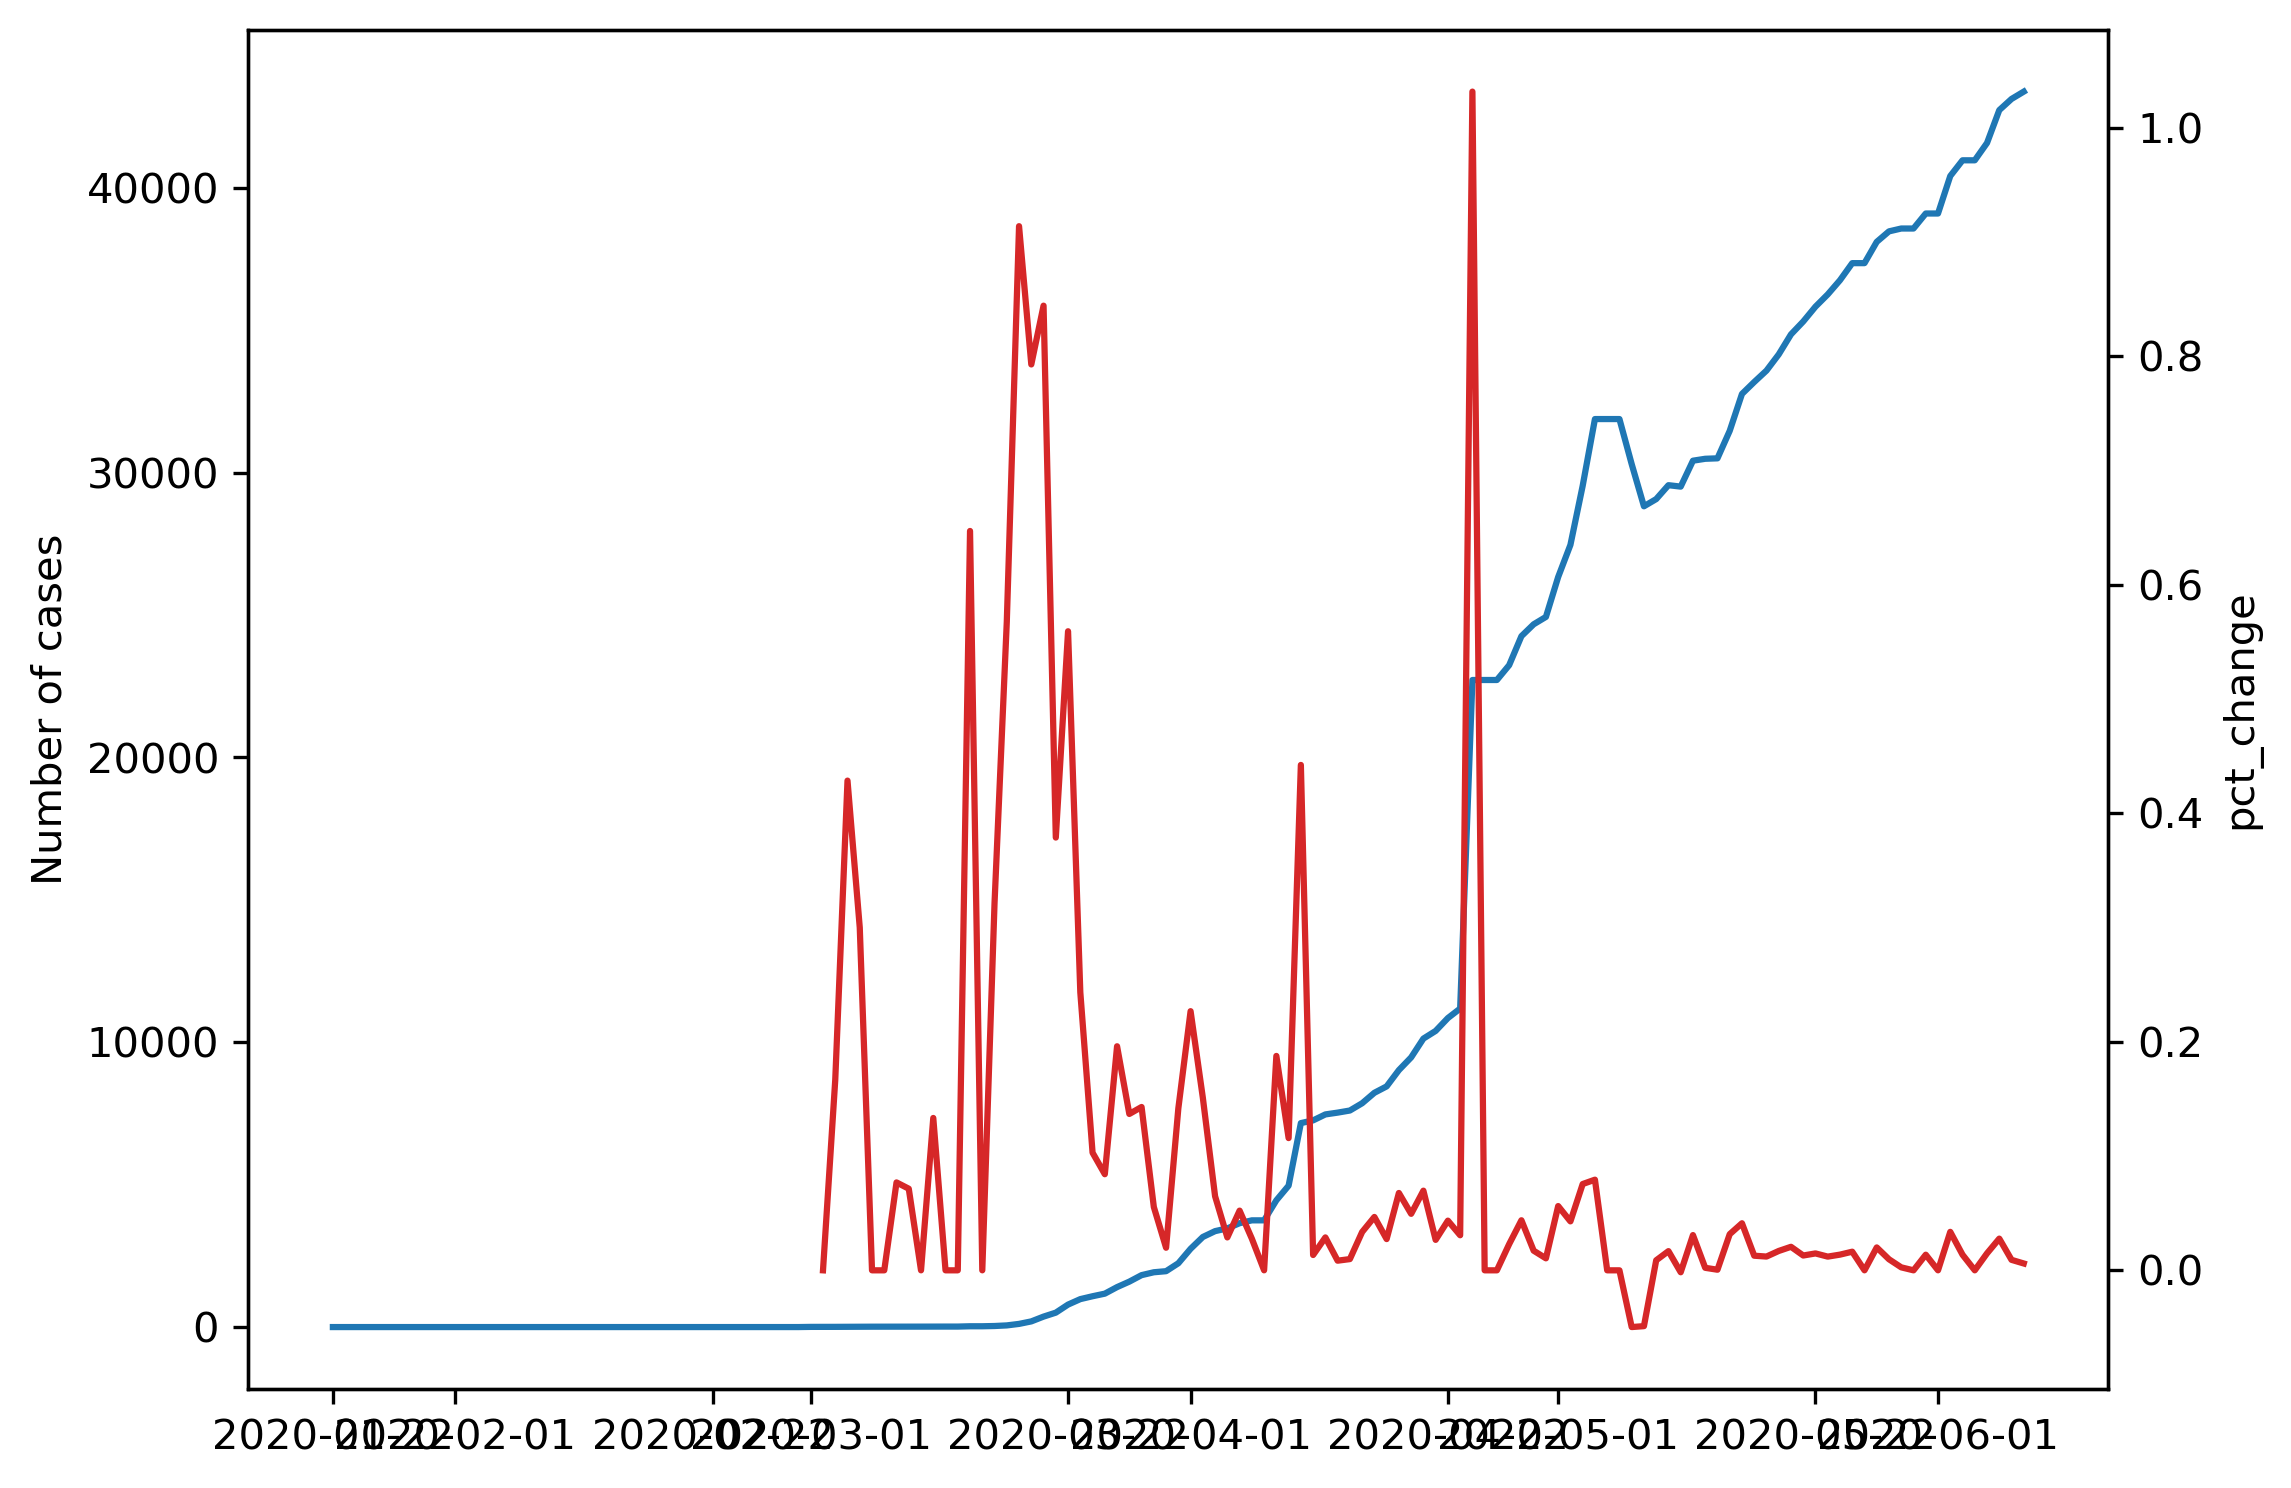

In [54]:
cases_and_rate(df_by_country['Ecuador'])

In [55]:
df_by_country['Ecuador']

2020-01-22        0
2020-01-23        0
2020-01-24        0
2020-01-25        0
2020-01-26        0
              ...  
2020-06-04    40966
2020-06-05    41575
2020-06-06    42728
2020-06-07    43120
2020-06-08    43378
Name: Ecuador, Length: 139, dtype: int64

Seems to be a counting artifact? The case count changes do not seem very smooth, and almost resemble a "leaky" step function.

In [56]:
last_crossed_07499_series = dates_last_crossed_07499.to_frame(name='Date')
last_crossed_07499_series['Case Count'] = [df_by_country[x][dates_last_crossed_07499[x]:] for x in dates_last_crossed_07499.index]
last_crossed_07499_series

Date  \
Country/Region                   
Afghanistan         2020-03-24   
Albania             2020-03-12   
Algeria             2020-03-04   
Andorra             2020-03-17   
Angola              2020-03-21   
...                        ...   
West Bank and Gaza  2020-03-07   
Western Sahara      2020-04-05   
Yemen               2020-05-05   
Zambia              2020-03-25   
Zimbabwe            2020-05-27   

                                                           Case Count  
Country/Region                                                         
Afghanistan         2020-03-24       74
2020-03-25       84
2020-0...  
Albania             2020-03-12      23
2020-03-13      33
2020-03-...  
Algeria             2020-03-04       12
2020-03-05       12
2020-0...  
Andorra             2020-03-17     39
2020-03-18     39
2020-03-19...  
Angola              2020-03-21     2
2020-03-22     2
2020-03-23  ...  
...                                                               ...  
West Bank and Gaza  2020-03-07     16
2020-03-08     16
2020-03-09...  
Western Sahara      2020-04-05    4
2020-04-06    4
2020-04-07    ...  
Yemen               2020-05-05     22
2020-05-06     25
2020-05-07...  
Zambia              2020-03-25      12
2020-03-26      16
2020-03-...  
Zimbabwe            2020-05-27    132
2020-05-28    149
2020-05-29...  

[188 rows x 2 columns]

In [57]:
df_by_country['US'][dates_last_crossed_07499['US']:].values

array([  13748,   19274,   25600,   33280,   43862,   53925,   65844,
         83836,  101962,  121786,  140910,  162147,  188172,  213602,
        244008,  275798,  309027,  336802,  366317,  397121,  428654,
        463327,  496846,  526776,  555313,  580624,  607670,  636674,
        667981,  700062,  732590,  758809,  784708,  811865,  840351,
        869170,  905358,  938154,  965785,  988197, 1012582, 1039909,
       1069424, 1103461, 1132539, 1158040, 1180375, 1204351, 1229331,
       1257023, 1283929, 1309550, 1329260, 1347881, 1369376, 1390406,
       1417774, 1442824, 1467820, 1486757, 1508308, 1528568, 1551853,
       1577147, 1600937, 1622612, 1643246, 1662302, 1680913, 1699176,
       1721753, 1746019, 1770165, 1790172, 1811020, 1831821, 1851520,
       1872660, 1897380, 1920061, 1943647, 1960897])

In [58]:
{x:df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index}

{'Afghanistan': array([   74,    84,    94,   110,   110,   120,   170,   174,   237,
          273,   281,   299,   349,   367,   423,   444,   484,   521,
          555,   607,   665,   714,   784,   840,   906,   933,   996,
         1026,  1092,  1176,  1279,  1351,  1463,  1531,  1703,  1828,
         1939,  2171,  2335,  2469,  2704,  2894,  3224,  3392,  3563,
         3778,  4033,  4402,  4687,  4963,  5226,  5639,  6053,  6402,
         6664,  7072,  7653,  8145,  8676,  9216,  9998, 10582, 11173,
        11831, 12456, 13036, 13659, 14525, 15205, 15750, 16509, 17267,
        18054, 18969, 19551, 20342, 20917]),
 'Albania': array([  23,   33,   38,   42,   51,   55,   59,   64,   70,   76,   89,
         104,  123,  146,  174,  186,  197,  212,  223,  243,  259,  277,
         304,  333,  361,  377,  383,  400,  409,  416,  433,  446,  467,
         475,  494,  518,  539,  548,  562,  584,  609,  634,  663,  678,
         712,  726,  736,  750,  766,  773,  782,  789,  795,  80

In [59]:
len([df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index])

188

In [60]:
cases_after_cross_07499 = pd.DataFrame(data=[df_by_country[x][dates_last_crossed_07499[x]:].values for x in dates_last_crossed_07499.index],
                                   #columns=dates_last_crossed_07499.index
                                  )
cases_after_cross_07499 = cases_after_cross_07499.transpose()
cases_after_cross_07499.columns=[x for x in dates_last_crossed_07499.index]
cases_after_cross_07499

Afghanistan  Albania  Algeria  Andorra  Angola  Antigua and Barbuda  \
0           74.0     23.0     12.0     39.0     2.0                  7.0   
1           84.0     33.0     12.0     39.0     2.0                  7.0   
2           94.0     38.0     17.0     53.0     3.0                  7.0   
3          110.0     42.0     17.0     75.0     3.0                  7.0   
4          110.0     51.0     19.0     88.0     3.0                  7.0   
..           ...      ...      ...      ...     ...                  ...   
132          NaN      NaN      NaN      NaN     NaN                  NaN   
133          NaN      NaN      NaN      NaN     NaN                  NaN   
134          NaN      NaN      NaN      NaN     NaN                  NaN   
135          NaN      NaN      NaN      NaN     NaN                  NaN   
136          NaN      NaN      NaN      NaN     NaN                  NaN   

     Argentina  Armenia  Australia  Austria  ...  United Kingdom  Uruguay  \
0          8.0     52.0        4.0      9.0  ...             8.0     29.0   
1         12.0     78.0        5.0     14.0  ...             8.0     50.0   
2         12.0     84.0        5.0     18.0  ...             9.0     79.0   
3         17.0    115.0        6.0     21.0  ...             9.0     94.0   
4         19.0    136.0        9.0     29.0  ...             9.0    110.0   
..         ...      ...        ...      ...  ...             ...      ...   
132        NaN      NaN     7259.0      NaN  ...             NaN      NaN   
133        NaN      NaN     7265.0      NaN  ...             NaN      NaN   
134        NaN      NaN     7267.0      NaN  ...             NaN      NaN   
135        NaN      NaN        NaN      NaN  ...             NaN      NaN   
136        NaN      NaN        NaN      NaN  ...             NaN      NaN   

     Uzbekistan  Venezuela  Vietnam  West Bank and Gaza  Western Sahara  \
0           6.0       33.0      6.0                16.0             4.0   
1          10.0       36.0      6.0                16.0             4.0   
2          15.0       42.0      8.0                19.0             4.0   
3          23.0       42.0      8.0                26.0             4.0   
4          33.0       70.0      8.0                30.0             4.0   
..          ...        ...      ...                 ...             ...   
132         NaN        NaN      NaN                 NaN             NaN   
133         NaN        NaN      NaN                 NaN             NaN   
134         NaN        NaN      NaN                 NaN             NaN   
135         NaN        NaN      NaN                 NaN             NaN   
136         NaN        NaN      NaN                 NaN             NaN   

     Yemen  Zambia  Zimbabwe  
0     22.0    12.0     132.0  
1     25.0    16.0     149.0  
2     25.0    22.0     149.0  
3     34.0    28.0     174.0  
4     34.0    29.0     178.0  
..     ...     ...       ...  
132    NaN     NaN       NaN  
133    NaN     NaN       NaN  
134    NaN     NaN       NaN  
135    NaN     NaN       NaN  
136    NaN     NaN       NaN  

[137 rows x 188 columns]

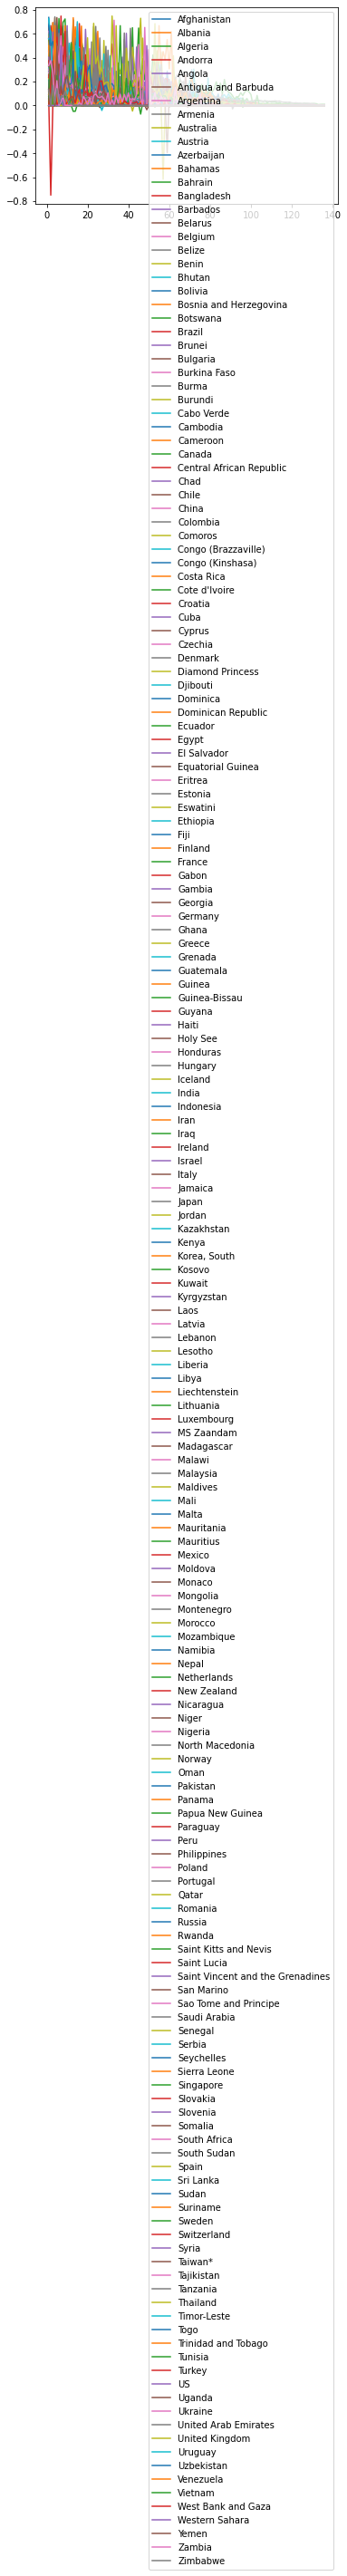

In [61]:
cases_after_cross_07499.pct_change().plot()

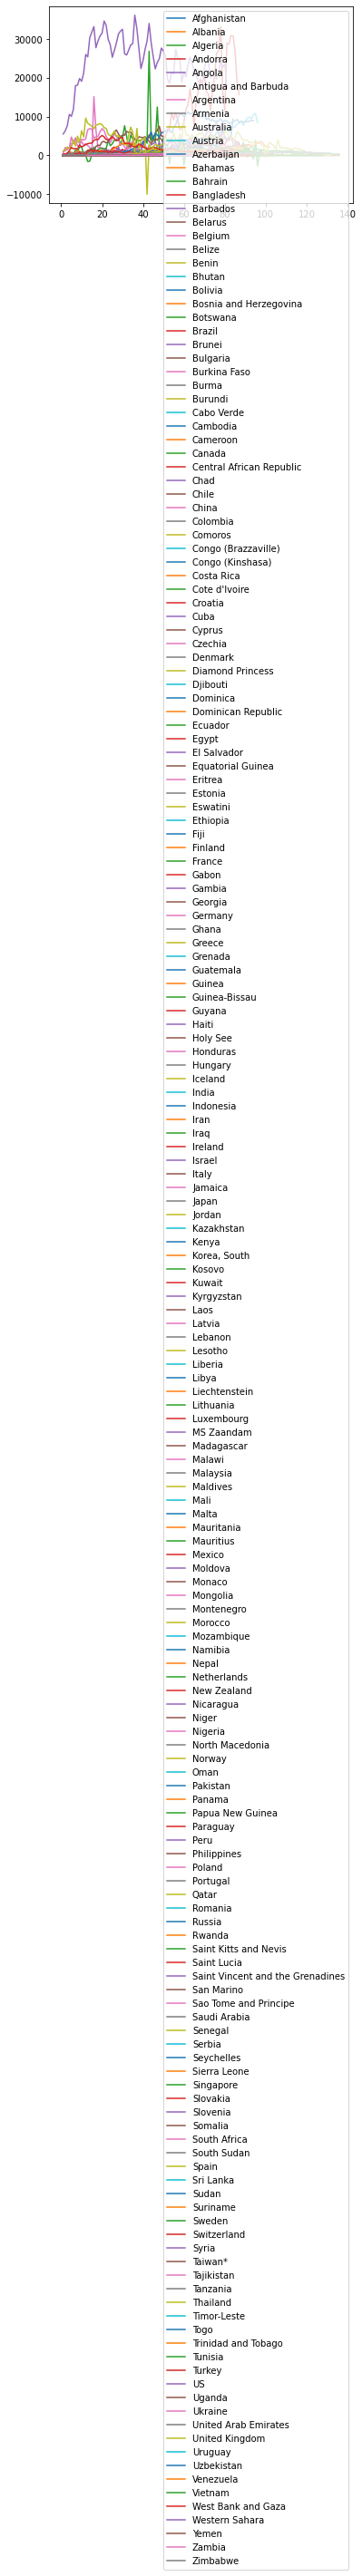

In [62]:
cases_after_cross_07499.diff().plot()

In [63]:
cases_after_cross_07499.dropna(axis=1)

Singapore  Taiwan*
0          3.0      3.0
1          3.0      3.0
2          4.0      4.0
3          5.0      5.0
4          7.0      8.0
..         ...      ...
132    36922.0    443.0
133    37183.0    443.0
134    37527.0    443.0
135    37910.0    443.0
136    38296.0    443.0

[137 rows x 2 columns]

In [64]:
cases_after_cross_07499[cases_after_cross_07499.pct_change() < 0].dropna(axis=1)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[137 rows x 0 columns]

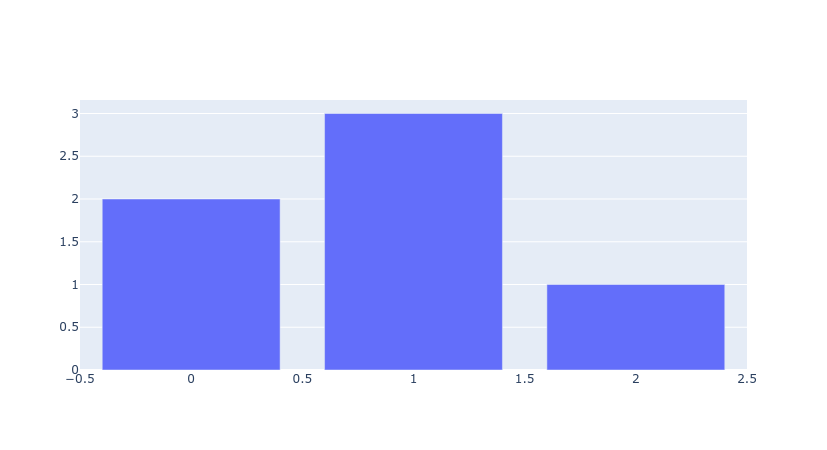

In [65]:
# sample plotly figure from quickstart
ptlyfig = go.Figure(data=go.Bar(y=[2, 3, 1]))
ptlyfig.show()

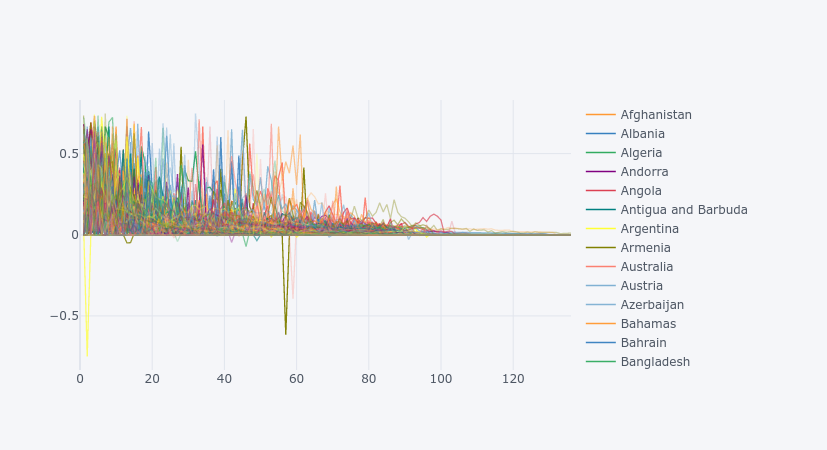

In [66]:
# using .figure() instead of .iplot(), otherwise the following error is obtained:
# PlotlyRequestError: Authentication credentials were not provided.
cases_after_cross_07499.pct_change().figure()

In [67]:
cases_after_cross_07499['Guyana']

0      19.0
1      20.0
2       5.0
3       5.0
4       5.0
       ... 
132     NaN
133     NaN
134     NaN
135     NaN
136     NaN
Name: Guyana, Length: 137, dtype: float64

## Code snippets

In [68]:
def process_JHU():
    
    dfs = {}
    
    # First, retrieve data
    for x in ['confirmed','deaths','recovered']:
        dfs[x + '_RAW'] = (pd.read_csv(TIME_SERIES_PATH + CSV_URL[upper(x)])
                           .rename(columns=_process_columns)
                          )
    
    for x in ['confirmed','deaths']:
        dfs[x + '_US_RAW'] = (pd.read_csv(TIME_SERIES_PATH + CSV_URL['US_' + upper(x)])
                              .rename(columns={'Long_': 'Long',
                                               'Country_Region': 'Country/Region',
                                               'Province_State': 'Province/State'
                                              })
                              .rename(columns=_process_columns)
                             )
        dfs[x + '_GLOBAL'] = _concatenate_US() # concatenate both US and global data
        dfs[x + '_COUNTRY'] = _country_level(dfs[x + '_GLOBAL']) # Generate country-level data
    
    def _country_level(df):
        '''Generate country-level dataframe of numbers from concatenated dataframes.
        '''
        temp_df = df.drop(['Lat', 'Long', 'Province/State'])
        temp_df = pd.pivot_table(temp_df,
                                 index=['Country/Region'],
                                 aggfunc=np.sum
                                )
        return temp_df
    
    def _concatenate_US(global_df, us_df):
        '''Concatenate both dataframes to return country-level information.
        Discards data more granular than the province/state level.
        '''
        temp_df = us_df.copy()
        excess_cols = set(us_df.columns) - set(global_df.columns)
        temp_df = temp_df.drop(excess_cols)
        return temp_df
    
    def _process_columns(col_name):
        try: 
            return dt.datetime.strptime(col_name, '%m/%d/%y').date()
        except ValueError:
            return col_name

In [69]:
[_process_columns(x) for x in df_confirmed.columns[4:]]

[datetime.date(2020, 1, 22),
 datetime.date(2020, 1, 23),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 1, 27),
 datetime.date(2020, 1, 28),
 datetime.date(2020, 1, 29),
 datetime.date(2020, 1, 30),
 datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 3),
 datetime.date(2020, 2, 4),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 6),
 datetime.date(2020, 2, 7),
 datetime.date(2020, 2, 8),
 datetime.date(2020, 2, 9),
 datetime.date(2020, 2, 10),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 2, 12),
 datetime.date(2020, 2, 13),
 datetime.date(2020, 2, 14),
 datetime.date(2020, 2, 15),
 datetime.date(2020, 2, 16),
 datetime.date(2020, 2, 17),
 datetime.date(2020, 2, 18),
 datetime.date(2020, 2, 19),
 datetime.date(2020, 2, 20),
 datetime.date(2020, 2, 21),
 datetime.date(2020, 2, 22),
 datetime.date(2020, 2, 23),
 datetime.date(2020, 2, 24),
 datetime.date(2020, 2,

## Population information

In [70]:
worldbank_pop_request = requests.get(WORLDBANK_POP_ZIP)
with zf.ZipFile(io.BytesIO(worldbank_pop_request.content), 'r') as wb_pop_zip:
    wb_pop_zip.extractall('tmp')

In [71]:
# to replace if possible
#POPULATION_CSV = "API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv"
#COUNTRY_METADATA_CSV = "Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv"

In [72]:
population_csvs = [x for x in os.listdir('tmp') if x.startswith("API_SP")]
file_dates = {}
for file in population_csvs:
    with open('tmp/' + file) as csvfile:
        reader = csv.reader(csvfile)
        for row in itertools.islice(reader, 2, 3):
            file_dates[file] = dt.datetime.strptime(row[1], "%Y-%m-%d").date()
POPULATION_CSV = max(file_dates)

In [73]:
df_worldbank_pop = pd.read_csv("tmp/" + POPULATION_CSV, skiprows=3, index_col="Country Name").iloc[:, :-2]
#df_country_metadata = pd.read_csv("tmp/" + COUNTRY_METADATA_CSV)

In [74]:
def retrieve_worldbank(wb_code):
    raw_csvs = [x for x in os.listdir('tmp') if x.startswith("API_" + wb_code)]
    file_dates = {}
    for file in raw_csvs:
        with open('tmp/' + file) as csvfile:
            reader = csv.reader(csvfile)
            for row in itertools.islice(reader, 2, 3):
                file_dates[file] = dt.datetime.strptime(row[1], "%Y-%m-%d").date()
    return pd.read_csv("tmp/" + max(file_dates), skiprows=3, index_col="Country Name").iloc[:, :-2]

def latest_worldbank(wb_code):
    return retrieve_worldbank(wb_code).iloc[:, [0, -1]]

In [75]:
df_worldbank_pop

Country Code                            Indicator Name  \
Country Name                                                          
Aruba                 ABW  Urban population (% of total population)   
Afghanistan           AFG  Urban population (% of total population)   
Angola                AGO  Urban population (% of total population)   
Albania               ALB  Urban population (% of total population)   
Andorra               AND  Urban population (% of total population)   
...                   ...                                       ...   
Kosovo                XKX  Urban population (% of total population)   
Yemen, Rep.           YEM  Urban population (% of total population)   
South Africa          ZAF  Urban population (% of total population)   
Zambia                ZMB  Urban population (% of total population)   
Zimbabwe              ZWE  Urban population (% of total population)   

                 Indicator Code    1960    1961    1962    1963    1964  \
Country Name                                                              
Aruba         SP.URB.TOTL.IN.ZS  50.776  50.761  50.746  50.730  50.715   
Afghanistan   SP.URB.TOTL.IN.ZS   8.401   8.684   8.976   9.276   9.586   
Angola        SP.URB.TOTL.IN.ZS  10.435  10.798  11.204  11.624  12.058   
Albania       SP.URB.TOTL.IN.ZS  30.705  30.943  31.015  31.086  31.158   
Andorra       SP.URB.TOTL.IN.ZS  58.450  60.983  63.462  65.872  68.205   
...                         ...     ...     ...     ...     ...     ...   
Kosovo        SP.URB.TOTL.IN.ZS     NaN     NaN     NaN     NaN     NaN   
Yemen, Rep.   SP.URB.TOTL.IN.ZS   9.100   9.459   9.831  10.216  10.614   
South Africa  SP.URB.TOTL.IN.ZS  46.619  46.793  46.906  47.020  47.134   
Zambia        SP.URB.TOTL.IN.ZS  18.145  18.951  19.785  20.712  22.015   
Zimbabwe      SP.URB.TOTL.IN.ZS  12.608  12.821  13.082  13.578  14.092   

                1965    1966  ...    2009    2010    2011    2012    2013  \
Country Name                  ...                                           
Aruba         50.700  50.685  ...  43.421  43.059  42.940  42.957  42.990   
Afghanistan    9.904  10.233  ...  23.528  23.737  23.948  24.160  24.373   
Angola        12.504  12.965  ...  59.034  59.783  60.528  61.268  62.002   
Albania       31.230  31.302  ...  51.076  52.163  53.247  54.330  55.387   
Andorra       70.445  72.593  ...  88.912  88.819  88.726  88.631  88.537   
...              ...     ...  ...     ...     ...     ...     ...     ...   
Kosovo           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
Yemen, Rep.   11.026  11.451  ...  31.194  31.776  32.364  32.958  33.559   
South Africa  47.248  47.362  ...  61.687  62.218  62.746  63.272  63.793   
Zambia        23.372  24.789  ...  38.861  39.355  39.851  40.354  40.865   
Zimbabwe      14.620  15.165  ...  33.378  33.196  33.015  32.834  32.654   

                2014    2015    2016    2017    2018  
Country Name                                          
Aruba         43.041  43.108  43.192  43.293  43.411  
Afghanistan   24.587  24.803  25.020  25.250  25.495  
Angola        62.731  63.446  64.149  64.839  65.514  
Albania       56.423  57.434  58.421  59.383  60.319  
Andorra       88.441  88.345  88.248  88.150  88.062  
...              ...     ...     ...     ...     ...  
Kosovo           NaN     NaN     NaN     NaN     NaN  
Yemen, Rep.   34.165  34.777  35.394  36.016  36.642  
South Africa  64.312  64.828  65.341  65.850  66.355  
Zambia        41.382  41.907  42.438  42.976  43.521  
Zimbabwe      32.504  32.385  32.296  32.237  32.209  

[264 rows x 62 columns]

In [76]:
latest_worldbank_pop = df_worldbank_pop.iloc[:, [0, -1]]
latest_worldbank_pop

Country Code    2018
Country Name                     
Aruba                 ABW  43.411
Afghanistan           AFG  25.495
Angola                AGO  65.514
Albania               ALB  60.319
Andorra               AND  88.062
...                   ...     ...
Kosovo                XKX     NaN
Yemen, Rep.           YEM  36.642
South Africa          ZAF  66.355
Zambia                ZMB  43.521
Zimbabwe              ZWE  32.209

[264 rows x 2 columns]

In [77]:
latest_worldbank_pop.loc['Aruba'].iloc[-1]

43.411

Unfortunately, the country list for the two datasets do not correspond one-to-one.

In [78]:
set(df_by_country.columns) - set(latest_worldbank_pop.index)

{'Bahamas',
 'Brunei',
 'Burma',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Czechia',
 'Diamond Princess',
 'Egypt',
 'Gambia',
 'Holy See',
 'Iran',
 'Korea, South',
 'Kyrgyzstan',
 'Laos',
 'MS Zaandam',
 'Russia',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Slovakia',
 'Syria',
 'Taiwan*',
 'US',
 'Venezuela',
 'Western Sahara',
 'Yemen'}

We can see for a start, that two cruise vessels are included in the dataset, and should ideally be removed.

In [79]:
set(latest_worldbank_pop.index) - set(df_by_country.columns)

{'American Samoa',
 'Arab World',
 'Aruba',
 'Bahamas, The',
 'Bermuda',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Caribbean small states',
 'Cayman Islands',
 'Central Europe and the Baltics',
 'Channel Islands',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Curacao',
 'Czech Republic',
 'Early-demographic dividend',
 'East Asia & Pacific',
 'East Asia & Pacific (IDA & IBRD countries)',
 'East Asia & Pacific (excluding high income)',
 'Egypt, Arab Rep.',
 'Euro area',
 'Europe & Central Asia',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Europe & Central Asia (excluding high income)',
 'European Union',
 'Faroe Islands',
 'Fragile and conflict affected situations',
 'French Polynesia',
 'Gambia, The',
 'Gibraltar',
 'Greenland',
 'Guam',
 'Heavily indebted poor countries (HIPC)',
 'High income',
 'Hong Kong SAR, China',
 'IBRD only',
 'IDA & IBRD total',
 'IDA blend',
 'IDA only',
 'IDA total',
 'Iran, Islamic Rep.',
 'Isle of Man',
 'Kiribati',
 'Korea, Dem. People’s Rep.',
 

In [80]:
{x:difflib.get_close_matches(x, latest_worldbank_pop.index, n=5, cutoff=0.3) for x in (set(df_by_country.columns) - set(latest_worldbank_pop.index))}

{'Congo (Kinshasa)': ['Mongolia',
  'Hong Kong SAR, China',
  'Congo, Rep.',
  'Colombia',
  'Solomon Islands'],
 'Taiwan*': ['Thailand', 'Tajikistan', 'Tanzania', 'Pakistan', 'Spain'],
 'Egypt': ['Egypt, Arab Rep.', 'Cyprus', 'Uruguay', 'Hungary', 'Estonia'],
 'Slovakia': ['Slovenia', 'Somalia', 'Slovak Republic', 'Romania', 'Moldova'],
 'Yemen': ['Yemen, Rep.', 'Sweden', 'Germany', 'Armenia', 'Cameroon'],
 'Syria': ['Serbia', 'Suriname', 'Sri Lanka', 'Somalia', 'Nigeria'],
 'Holy See': ['Cabo Verde', 'Sweden', 'Senegal', 'IDA only', 'IBRD only'],
 'Korea, South': ['Korea, Rep.',
  'South Asia',
  'South Sudan',
  'Korea, Dem. People’s Rep.',
  'Micronesia, Fed. Sts.'],
 'Saint Vincent and the Grenadines': ['St. Vincent and the Grenadines',
  'St. Kitts and Nevis',
  'Sao Tome and Principe',
  'Central Europe and the Baltics',
  'Bosnia and Herzegovina'],
 'MS Zaandam': ['New Zealand', 'Sri Lanka', 'Uganda', 'Rwanda', 'Panama'],
 'Saint Kitts and Nevis': ['St. Kitts and Nevis',
  'St.

In [81]:
[x for x in filter(lambda x: x.startswith('U'), latest_worldbank_pop.index)]

['United Arab Emirates',
 'United Kingdom',
 'Uganda',
 'Ukraine',
 'Upper middle income',
 'Uruguay',
 'United States',
 'Uzbekistan']

In [82]:
[x for x in filter(lambda x: x.startswith('S'), latest_worldbank_pop.index)]

['Switzerland',
 'Spain',
 'St. Kitts and Nevis',
 'St. Lucia',
 'Sri Lanka',
 'St. Martin (French part)',
 'South Asia',
 'Saudi Arabia',
 'Sudan',
 'Senegal',
 'Singapore',
 'Solomon Islands',
 'Sierra Leone',
 'San Marino',
 'Somalia',
 'Serbia',
 'Sub-Saharan Africa (excluding high income)',
 'South Sudan',
 'Sub-Saharan Africa',
 'Small states',
 'Sao Tome and Principe',
 'Suriname',
 'Slovak Republic',
 'Slovenia',
 'Sweden',
 'Sint Maarten (Dutch part)',
 'Seychelles',
 'Syrian Arab Republic',
 'South Asia (IDA & IBRD)',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'St. Vincent and the Grenadines',
 'Samoa',
 'South Africa']

In [83]:
worldbank_countries = {
    'Saint Kitts and Nevis': 'St. Kitts and Nevis',
    'Diamond Princess': '',
    'Congo (Kinshasa)': 'Congo, Dem. Rep.',
    'Korea, South': 'Korea, Rep.',
    'MS Zaandam': '',
    'Russia': 'Russian Federation',
    'Egypt': 'Egypt, Arab Rep.',
    'Venezuela': 'Venezuela, RB',
    'US': 'United States',
    'Syria': 'Syrian Arab Republic',
    'Kyrgyzstan': 'Kyrgyz Republic',
    'Yemen': 'Yemen, Rep.',
    'Gambia': 'Gambia, The',
    'Holy See': '',
    'Slovakia': 'Slovak Republic',
    'Laos': 'Lao PDR',
    'Congo (Brazzaville)': 'Congo, Rep.',
    'Czechia': 'Czech Republic',
    'Iran': 'Iran, Islamic Rep.',
    'Western Sahara': '',
    'Saint Lucia': 'St. Lucia',
    'Bahamas': 'Bahamas, The',
    'Taiwan*': '', # https://datahelpdesk.worldbank.org/knowledgebase/topics/19280-country-classification
    'Burma': 'Myanmar',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    'Brunei': 'Brunei Darussalam'
}

In [84]:
def calculate_case_rate(cases, population):
    result = cases.copy()
    for col in cases.columns:
        result[col] = 1000000 * cases[col]/population.loc[col].iloc[-1] # calculate cases per million
        
    return result

In [85]:
cases_per_capita = calculate_case_rate(df_by_country.drop(columns=[key for (key, value) in worldbank_countries.items() if value == '']),
                                       latest_worldbank_pop.rename(index={v:k for (k,v) in worldbank_countries.items()})
                                      )
cases_per_capita

Country/Region   Afghanistan       Albania       Algeria       Andorra  \
2020-01-22      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-23      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-24      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-25      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-26      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                      ...           ...           ...           ...   
2020-06-04      7.081389e+08  1.984449e+07  1.353592e+08  9.675002e+06   
2020-06-05      7.440282e+08  2.009317e+07  1.367911e+08  9.675002e+06   
2020-06-06      7.668562e+08  2.042474e+07  1.383745e+08  9.675002e+06   
2020-06-07      7.978819e+08  2.065684e+07  1.398064e+08  9.675002e+06   
2020-06-08      8.204354e+08  2.093868e+07  1.413347e+08  9.675002e+06   

Country/Region        Angola  Antigua and Barbuda     Argentina       Armenia  \
2020-01-22      0.000000e+00         0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-23      0.000000e+00         0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-24      0.000000e+00         0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-25      0.000000e+00         0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-26      0.000000e+00         0.000000e+00  0.000000e+00  0.000000e+00   
...                      ...                  ...           ...           ...   
2020-06-04      1.312697e+06         1.056954e+06  2.198433e+08  1.776909e+08   
2020-06-05      1.312697e+06         1.056954e+06  2.289866e+08  1.871289e+08   
2020-06-06      1.343224e+06         1.056954e+06  2.396865e+08  1.957909e+08   
2020-06-07      1.389016e+06         1.056954e+06  2.481115e+08  2.079209e+08   
2020-06-08      1.404280e+06         1.056954e+06  2.571024e+08  2.110089e+08   

Country/Region     Australia       Austria  ...  United Arab Emirates  \
2020-01-22      0.000000e+00  0.000000e+00  ...          0.000000e+00   
2020-01-23      0.000000e+00  0.000000e+00  ...          0.000000e+00   
2020-01-24      0.000000e+00  0.000000e+00  ...          0.000000e+00   
2020-01-25      0.000000e+00  0.000000e+00  ...          0.000000e+00   
2020-01-26      4.650514e+04  0.000000e+00  ...          0.000000e+00   
...                      ...           ...  ...                   ...   
2020-06-04      8.425569e+07  2.882653e+08  ...          4.278449e+08   
2020-06-05      8.431382e+07  2.889171e+08  ...          4.350570e+08   
2020-06-06      8.439520e+07  2.898605e+08  ...          4.422921e+08   
2020-06-07      8.446496e+07  2.899292e+08  ...          4.485333e+08   
2020-06-08      8.448821e+07  2.910613e+08  ...          4.550981e+08   

Country/Region  United Kingdom       Uruguay    Uzbekistan     Venezuela  \
2020-01-22        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-23        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-24        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-25        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-26        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                        ...           ...           ...           ...   
2020-06-04        3.394314e+09  8.727212e+06  7.803400e+07  2.365999e+07   
2020-06-05        3.414159e+09  8.748191e+06  7.938112e+07  2.431752e+07   
2020-06-06        3.432864e+09  8.863574e+06  8.110464e+07  2.625612e+07   
2020-06-07        3.448776e+09  8.863574e+06  8.579975e+07  2.694767e+07   
2020-06-08        3.463320e+09  8.863574e+06  8.795911e+07  2.803601e+07   

Country/Region       Vietnam  West Bank and Gaza         Yemen        Zambia  \
2020-01-22      0.000000e+00        0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-23      5.568084e+04        0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-24      5.568084e+04        0.000000e+00  0.000000e+00  0.000000e+00   
2020-01-25      5.568084e+04

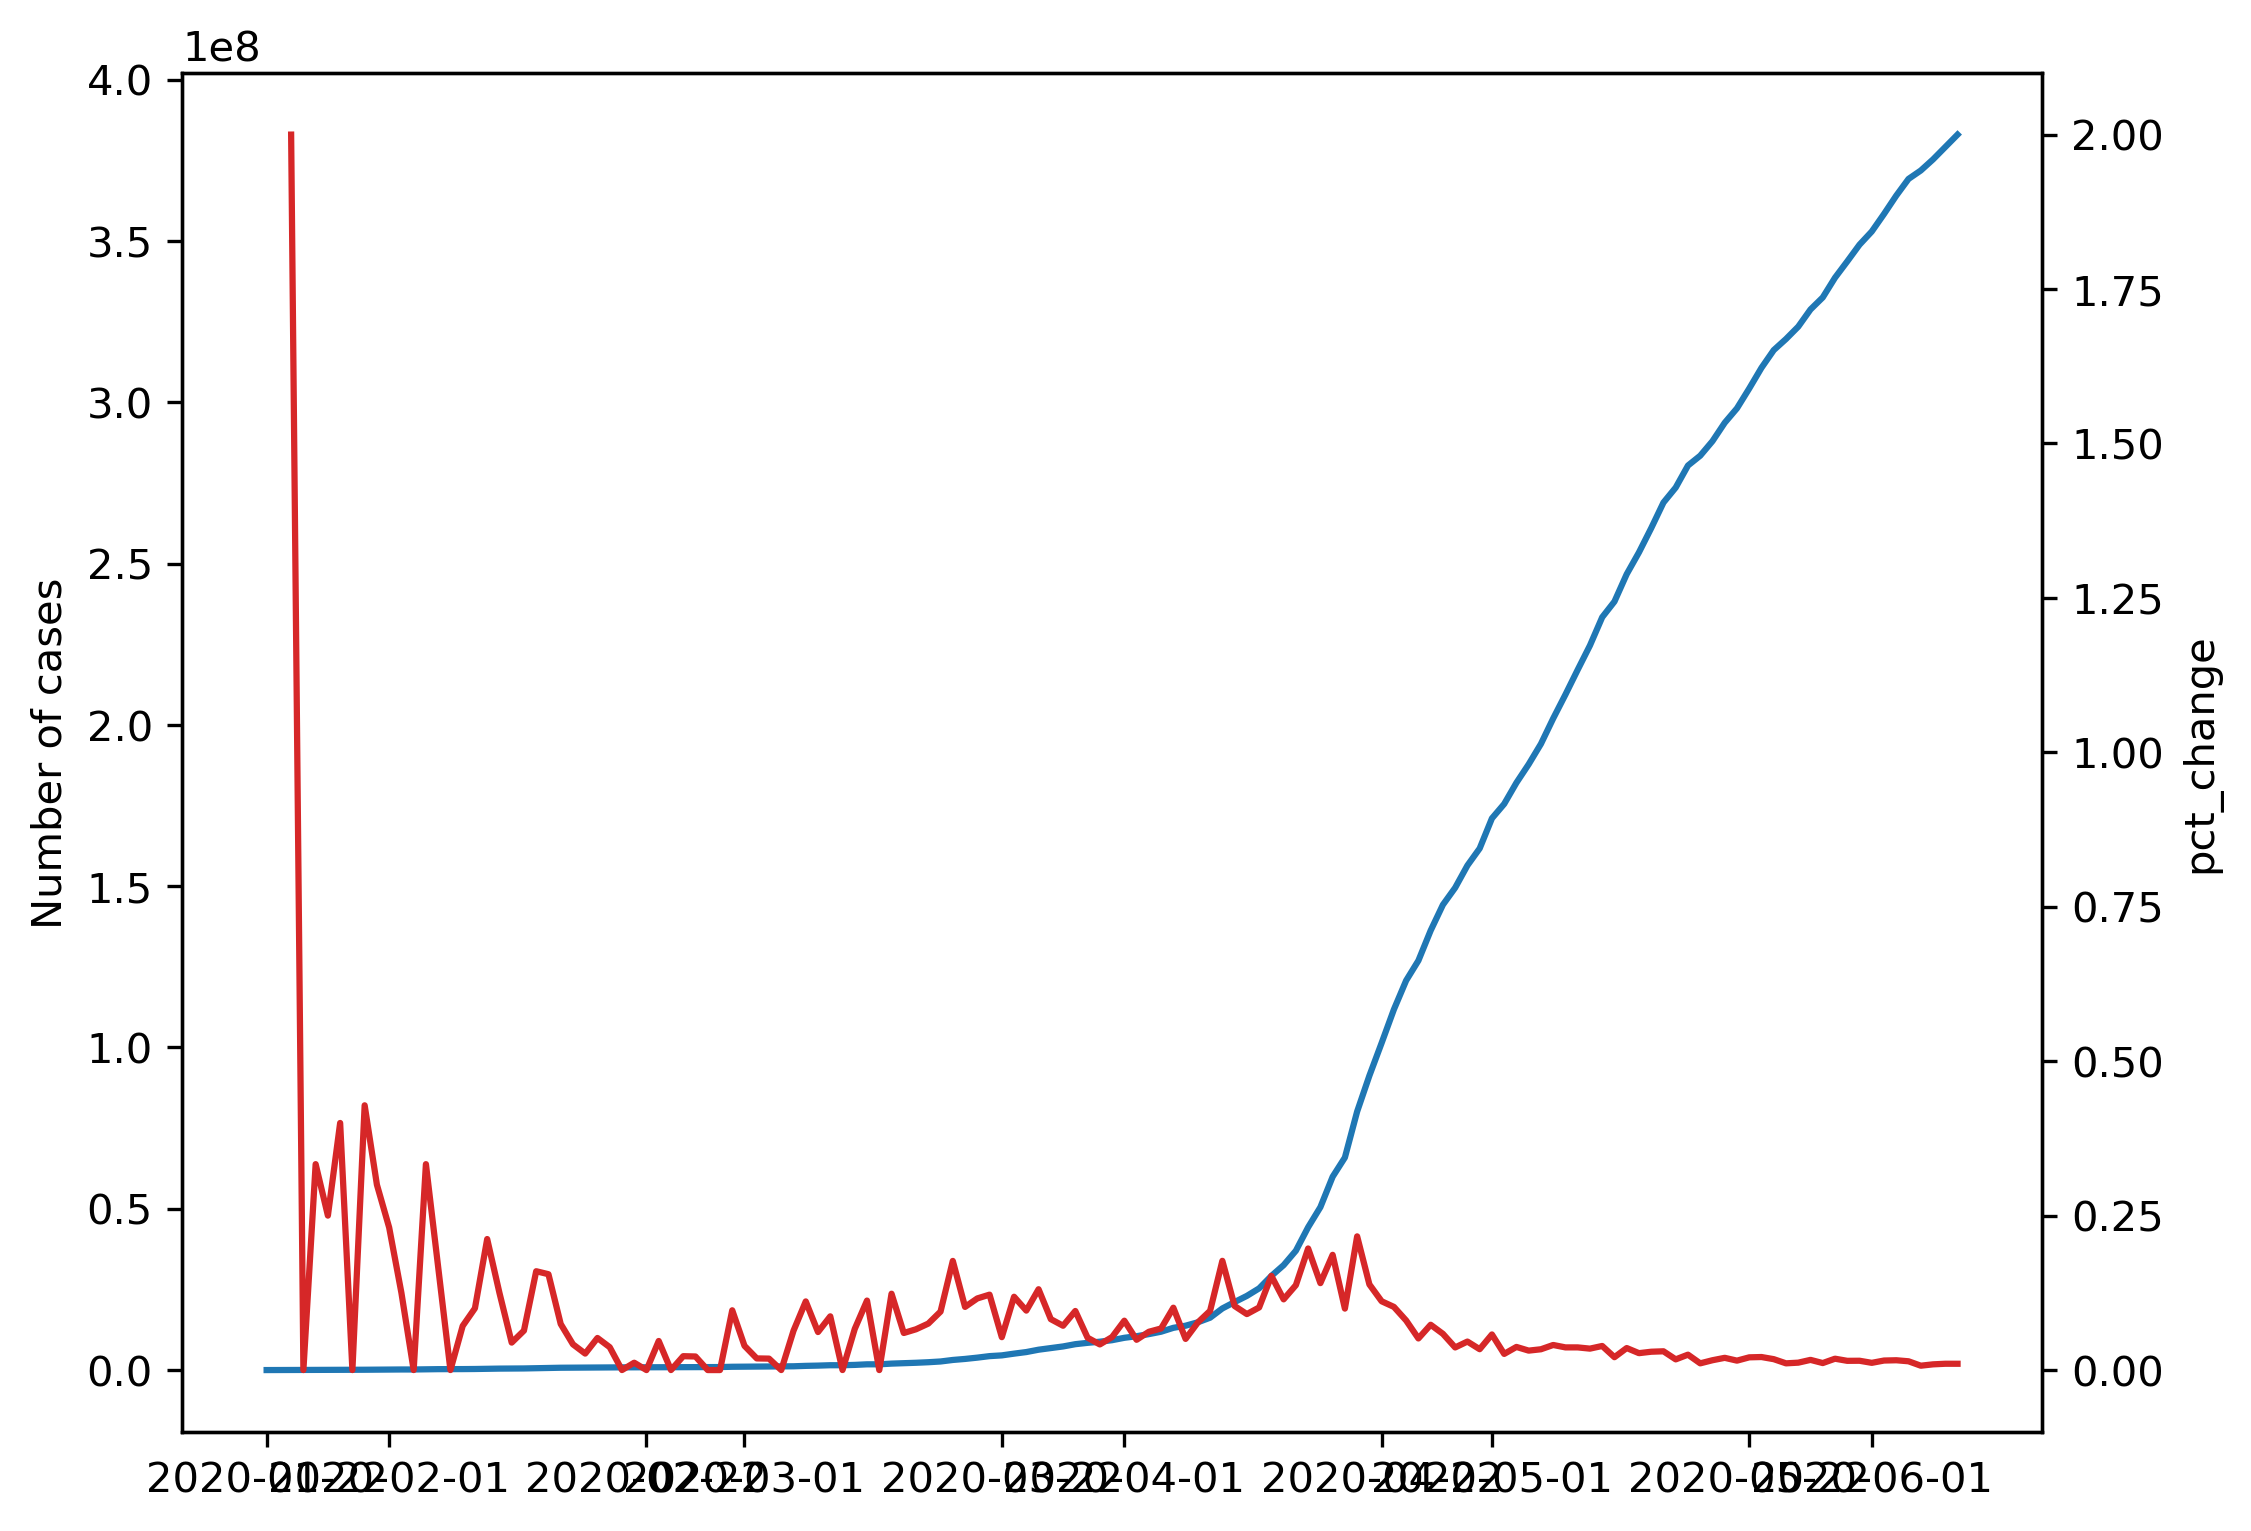

In [86]:
cases_and_rate(cases_per_capita['Singapore'])

# Urban population information

In [87]:
worldbank_urbpop_request = requests.get(WORLDBANK_URB_POP_ZIP)
with zf.ZipFile(io.BytesIO(worldbank_urbpop_request.content), 'r') as wb_urbpop_zip:
    wb_urbpop_zip.extractall('tmp')

In [88]:
df_wb_urban_population = latest_worldbank(WORLDBANK_URBPOP_CODE)

In [89]:
df_wb_urban_population

Country Code    2018
Country Name                     
Aruba                 ABW  43.411
Afghanistan           AFG  25.495
Angola                AGO  65.514
Albania               ALB  60.319
Andorra               AND  88.062
...                   ...     ...
Kosovo                XKX     NaN
Yemen, Rep.           YEM  36.642
South Africa          ZAF  66.355
Zambia                ZMB  43.521
Zimbabwe              ZWE  32.209

[264 rows x 2 columns]

In [90]:
df_wb_urban_population[df_wb_urban_population.iloc[:, -1].isna()]

Country Code  2018
Country Name                               
Eritrea                           ERI   NaN
Not classified                    INX   NaN
St. Martin (French part)          MAF   NaN
Kosovo                            XKX   NaN

Data does not appear to be available for 4 countries.

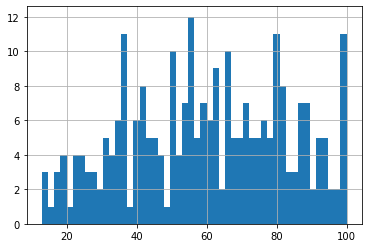

In [91]:
df_wb_urban_population.iloc[:, -1].hist(bins=50)

# University of Oxford Coronavirus Government Response Tracker 

In [ ]:
OXFORD_DATA_STARTDATE = "2020-01-02"
YESTERDAY = (dt.date.today() - dt.timedelta(days=1)).strftime('%Y-%m-%d')

## JSON Approach

In [98]:
OXFORD_API_URL = "https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range"

Reference JSON response: 
```JSON
{
  scale: Object //Scale for visualisations
    {
      deaths: Object, //Min and max int values in returned data
      confirmed: Object, //Min and max int values in returned data
      stringency: Object, //Min and max int values in returned data
    },
  countries:
    [
       Array of Strings //3 letter country codes in returned data
    ],
  data: {
    YYYY-MM-DD: {  //Key is date in YYYY-MM-DD format
      BRA: {  //3 letter country code
        date_value: YYYY-MM-DD, //Repeat of date in key
        country_code: BRA, //Repeat of country code in key
        confirmed: Integer, //Value of confirmed cases
        deaths: Integer, //Value of deaths
        stringency_actual: Integer, //Calculated value for day. Can be null if no value available
        stringency: Integer, //Display value for day **1.
        stringency_legacy: Integer, //Legacy calculation of stringency used until 28 April 2020,
        stringency_legacy_disp: Intenger, //Legacy display value for day (**1) used until 28 April 2020
      }
    }
  }
}

**1 Will be actual value if available. For previous 7 days will take last available value. Otherwise null.
```

In [108]:
oxford_api_query = '/'.join([OXFORD_API_URL, OXFORD_DATA_STARTDATE, YESTERDAY])
oxford_request = requests.get(oxford_api_query)
oxford_dict = oxford_request.json()

In [109]:
oxford_df = pd.DataFrame(oxford_dict['data'])

In [114]:
oxford_df.iloc[2,2]

{'date_value': '2020-01-04',
 'country_code': 'AUS',
 'confirmed': 0,
 'deaths': 0,
 'stringency_actual': 0,
 'stringency': 0,
 'stringency_legacy': 0,
 'stringency_legacy_disp': 0}

## Github approach

In [118]:
OXFORD_GITHUB_URL = "https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx"

In [144]:
def oxford_github_date_format(date):
    try:
        return dt.datetime.strptime(date, '%d%b%Y').date()
    except ValueError:
        return date

In [182]:
oxtmp = pd.read_excel(io=OXFORD_GITHUB_URL, sheet_name=None)

In [183]:
def _check_country_codes(df):
    items = [set(oxtmp[i].iloc[:, 0]) for i in df]
    return all(x == items[0] for x in items)

In [184]:
_check_country_codes(oxtmp)

True

In [185]:
for i in oxtmp: 
    oxtmp[i] = (oxtmp[i].drop(index=oxtmp[i].index[-3:])
                .drop(columns='CountryCode')
                .set_index('CountryName')
                .rename(columns=oxford_github_date_format)
                .transpose()
               )

In [197]:
def oxford_dfs_from_github(gh_url):
    '''
    Returns a "tidy" dictionary of dataframes from the University of Oxford COVID-9 Government Response Tracker Github repository.
    
    Parameters
    ----------
    gh_url : str
        URL of Oxford COVID-19 Government Response Tracker data.
    '''
    def _oxford_github_date_format(date):
        try:
            return dt.datetime.strptime(date, '%d%b%Y').date()
        except ValueError:
            return date
        
    def _check_country_codes(df):
        items = [set(temp[i].iloc[:, 0]) for i in df]
        return all(x == items[0] for x in items)
    
    temp = pd.read_excel(io=gh_url, sheet_name=None)
    if not _check_country_codes(temp):
        print("Country codes not equal. Check.")
        return None
    for i in temp:
        temp[i] = (temp[i].drop(columns='CountryCode')
                   .drop(index=temp[i].index[-3:])
                   .set_index('CountryName')
                   .rename(columns=_oxford_github_date_format)
                   .transpose()
                  )
    result = temp
    return result

In [198]:
oxford_data_from_github = oxford_dfs_from_github(OXFORD_GITHUB_URL)
oxford_data_from_github

{'c1_schoolclosing': CountryName  Aruba  Afghanistan  Angola  Albania  Andorra  \
 2020-01-01     0.0          0.0     0.0      0.0      0.0   
 2020-01-02     0.0          0.0     0.0      0.0      0.0   
 2020-01-03     0.0          0.0     0.0      0.0      0.0   
 2020-01-04     0.0          0.0     0.0      0.0      0.0   
 2020-01-05     0.0          0.0     0.0      0.0      0.0   
 ...            ...          ...     ...      ...      ...   
 2020-06-04     NaN          3.0     3.0      2.0      NaN   
 2020-06-05     NaN          3.0     NaN      NaN      NaN   
 2020-06-06     NaN          3.0     NaN      NaN      NaN   
 2020-06-07     NaN          3.0     NaN      NaN      NaN   
 2020-06-08     NaN          3.0     NaN      NaN      NaN   
 
 CountryName  United Arab Emirates  Argentina  Australia  Austria  Azerbaijan  \
 2020-01-01                    0.0        0.0        0.0      0.0         0.0   
 2020-01-02                    0.0        0.0        0.0      0.0       

# Google Mobility Data

In [93]:
temp = pd.read_csv(GOOG_MOBILITY_URL)
temp

/home/jay/anaconda3/envs/data-sandbox/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



country_region_code        country_region       sub_region_1  \
0                       AE  United Arab Emirates                NaN   
1                       AE  United Arab Emirates                NaN   
2                       AE  United Arab Emirates                NaN   
3                       AE  United Arab Emirates                NaN   
4                       AE  United Arab Emirates                NaN   
...                    ...                   ...                ...   
477317                  ZW              Zimbabwe  Midlands Province   
477318                  ZW              Zimbabwe  Midlands Province   
477319                  ZW              Zimbabwe  Midlands Province   
477320                  ZW              Zimbabwe  Midlands Province   
477321                  ZW              Zimbabwe  Midlands Province   

       sub_region_2        date  \
0               NaN  2020-02-15   
1               NaN  2020-02-16   
2               NaN  2020-02-17   
3               NaN  2020-02-18   
4               NaN  2020-02-19   
...             ...         ...   
477317          NaN  2020-05-25   
477318          NaN  2020-05-26   
477319          NaN  2020-05-27   
477320          NaN  2020-05-28   
477321          NaN  2020-05-29   

        retail_and_recreation_percent_change_from_baseline  \
0                                                     0.0    
1                                                     1.0    
2                                                    -1.0    
3                                                    -2.0    
4                                                    -2.0    
...                                                   ...    
477317                                                NaN    
477318                                                NaN    
477319                                                NaN    
477320                                                NaN    
477321                                                NaN    

        grocery_and_pharmacy_percent_change_from_baseline  \
0                                                     4.0   
1                                                     4.0   
2                                                     1.0   
3                                                     1.0   
4                                                     0.0   
...                                                   ...   
477317                                                NaN   
477318                                                NaN   
477319                                                NaN   
477320                                                NaN   
477321                                                NaN   

        parks_percent_change_from_baseline  \
0                                      5.0   
1                                      4.0   
2                                      5.0   
3                                      5.0   
4                                      4.0   
...                                    ...   
477317                                 NaN   
477318                                 NaN   
477319                                 NaN   
477320                                 NaN   
477321                                 NaN   

        transit_stations_percent_change_from_baseline  \
0                                                 0.0   
1                                                 1.0   
2                                                 1.0   
3                                                 0.0   
4                                                -1.0   
...                                               ...   
477317                                            NaN   
477318                                            NaN   
477319                                            NaN   
477320                                            NaN   
477321                                            NaN   

        workplace

Observations:
* Sub regions are present in data, which means some kind of processing will be needed in order to use this data.